<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Look-at-validation-set-and-reshape" data-toc-modified-id="Look-at-validation-set-and-reshape-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Look at validation set and reshape</a></span><ul class="toc-item"><li><span><a href="#Get-predictions" data-toc-modified-id="Get-predictions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Get predictions</a></span></li><li><span><a href="#Reshape" data-toc-modified-id="Reshape-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Reshape</a></span></li></ul></li><li><span><a href="#Check-out-energy-conservation" data-toc-modified-id="Check-out-energy-conservation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Check out energy conservation</a></span><ul class="toc-item"><li><span><a href="#Get-pressure-diffs" data-toc-modified-id="Get-pressure-diffs-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Get pressure diffs</a></span></li><li><span><a href="#Continue-with-budgets" data-toc-modified-id="Continue-with-budgets-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Continue with budgets</a></span></li></ul></li><li><span><a href="#Create-diagnostics-routine" data-toc-modified-id="Create-diagnostics-routine-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Create diagnostics routine</a></span><ul class="toc-item"><li><span><a href="#Plot-random-samples" data-toc-modified-id="Plot-random-samples-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Plot random samples</a></span></li><li><span><a href="#SPDT,-SPDQ-slices" data-toc-modified-id="SPDT,-SPDQ-slices-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>SPDT, SPDQ slices</a></span></li><li><span><a href="#PREC,-OLR-slices" data-toc-modified-id="PREC,-OLR-slices-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>PREC, OLR slices</a></span></li></ul></li></ul></div>

# Diagnostics for new predictions

- Understand reshaping
- Find way of loading predictions

In [8]:
# Imports
from losses import metrics
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))
from keras.utils.generic_utils import get_custom_objects
metrics_dict = dict([(f.__name__, f) for f in metrics])
get_custom_objects().update(metrics_dict)
from tqdm import tqdm
from data_generator import DataGenerator
import h5py

In [2]:
data_dir = '/local/S.Rasp/cbrain_data/'

## Look at validation set and reshape

In [39]:
valid_targets = xr.open_dataset(data_dir + 'valid_year1_targets.nc')
valid_features = xr.open_dataset(data_dir + 'valid_year1_features.nc')

The original dataset was reshaped from [time, lev, lat, lon] to [lev, sample], so sample=time, lat, lon. 

Then sample and lev were transposed to [sample, lev].

In [4]:
# Get first 2 days
n_lon = 128
n_lat = 64
n_geo = n_lat * n_lon
sample_targets = np.array(valid_targets.targets[:2*n_geo, :])
sample_features = np.array(valid_features.features[:2*n_geo, :])

NameError: name 'valid_targets' is not defined

In [41]:
sample_targets.shape, sample_features.shape

((16384, 86), (16384, 87))

### Get predictions

In [38]:
model = keras.models.load_model('./models/001_1year_noshuffle.h5')

In [42]:
preds = model.predict(sample_features)

In [43]:
preds.shape

(16384, 86)

### Reshape 

In [23]:
def reshape_geo(x):
    return x.reshape((-1, n_lat, n_lon, x.shape[-1]))

In [46]:
targets_re = sample_targets.reshape((-1, n_lat, n_lon, sample_targets.shape[-1]))
features_re = sample_features.reshape((-1, n_lat, n_lon, sample_features.shape[-1]))
preds_re = preds.reshape((-1, n_lat, n_lon, preds.shape[-1]))

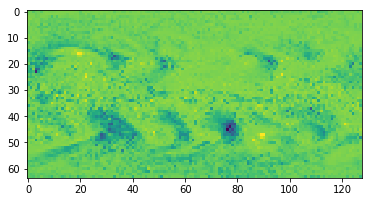

In [49]:
plt.imshow(targets_re[-1, :, :, 20]);

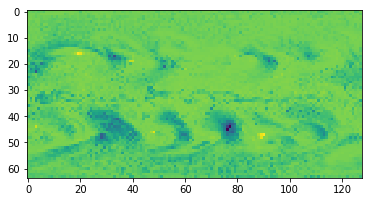

In [50]:
plt.imshow(preds_re[-1, :, :, 20]);

## Check out energy conservation

In [51]:
norm_file = xr.open_dataset(data_dir + 'year0_norm.nc')
norm_file

<xarray.Dataset>
Dimensions:        (feature_lev: 87, target_lev: 86)
Coordinates:
  * feature_lev    (feature_lev) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
  * target_lev     (target_lev) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
Data variables:
    feature_means  (feature_lev) float32 ...
    feature_stds   (feature_lev) float32 ...
    target_means   (target_lev) float32 ...
    target_stds    (target_lev) float32 ...
    feature_names  (feature_lev) object ...
    target_names   (target_lev) object ...
Attributes:
    log:      \n    Time: 2017-11-29T13:01:07\n\n    Executed command:\n\n   ...

In [54]:
features_re_unnorm = (features_re * np.array(norm_file.feature_stds) + 
                      np.array(norm_file.feature_means))

In [68]:
norm_file.feature_names[-2].values

array('LHFLX',
      dtype='<U5')

In [194]:
norm_file.target_names[21:42].values, norm_file.target_names[-2].values, norm_file.target_names[:21].values

(array(['SPDQ_lev09', 'SPDQ_lev10', 'SPDQ_lev11', 'SPDQ_lev12',
        'SPDQ_lev13', 'SPDQ_lev14', 'SPDQ_lev15', 'SPDQ_lev16',
        'SPDQ_lev17', 'SPDQ_lev18', 'SPDQ_lev19', 'SPDQ_lev20',
        'SPDQ_lev21', 'SPDQ_lev22', 'SPDQ_lev23', 'SPDQ_lev24',
        'SPDQ_lev25', 'SPDQ_lev26', 'SPDQ_lev27', 'SPDQ_lev28', 'SPDQ_lev29'], dtype=object),
 array('PRECT',
       dtype='<U5'),
 array(['SPDT_lev09', 'SPDT_lev10', 'SPDT_lev11', 'SPDT_lev12',
        'SPDT_lev13', 'SPDT_lev14', 'SPDT_lev15', 'SPDT_lev16',
        'SPDT_lev17', 'SPDT_lev18', 'SPDT_lev19', 'SPDT_lev20',
        'SPDT_lev21', 'SPDT_lev22', 'SPDT_lev23', 'SPDT_lev24',
        'SPDT_lev25', 'SPDT_lev26', 'SPDT_lev27', 'SPDT_lev28', 'SPDT_lev29'], dtype=object))

In [57]:
# Define conversion dict
L_V = 2.5e6   # Latent heat of vaporization is actually 2.26e6
C_P = 1e3 # Specific heat capacity of air at constant pressure
conversion_dict = {
    'SPDT': C_P,
    'SPDQ': L_V,
    'QRL': C_P,
    'QRS': C_P,
    'PRECT': 1e3*24*3600 * 1e-3,
    'FLUT': 1. * 1e-5,
}

In [107]:
# Moisture energy budget
spdq_vint = np.mean(targets_re[:, :, :, 21:42], axis=-1)
precip = targets_re[:, :, :, -2] / (1e3*24*3600 * 1e-3) * L_V*1e3
evap = features_re_unnorm[:, :, :, -2]

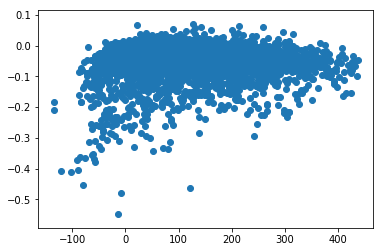

In [72]:
plt.scatter(evap-precip, spdq_vint)

### Get pressure diffs

In [125]:
aqua_file = xr.open_dataset('/project/meteo/w2w/A6/S.Rasp/SP-CAM/Aquaplanet/AndKua_aqua_SPCAM3.0.cam2.h1.0001-01-01-00000.nc', decode_times=False)

In [126]:
aqua_file

<xarray.Dataset>
Dimensions:       (crm_x: 8, crm_y: 1, crm_z: 28, ilev: 31, isccp_prs: 7, isccp_prstau: 49, isccp_tau: 7, lat: 64, lev: 30, lon: 128, tbnd: 2, time: 48)
Coordinates:
  * lat           (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 -73.95 ...
  * lon           (lon) float64 0.0 2.812 5.625 8.438 11.25 14.06 16.88 ...
  * crm_x         (crm_x) float64 0.0 4.0 8.0 12.0 16.0 20.0 24.0 28.0
  * crm_y         (crm_y) float64 0.0
  * crm_z         (crm_z) float64 992.6 976.3 957.5 936.2 912.6 887.0 859.5 ...
  * lev           (lev) float64 3.643 7.595 14.36 24.61 38.27 54.6 72.01 ...
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 30.67 45.87 63.32 ...
  * isccp_prs     (isccp_prs) float64 90.0 245.0 375.0 500.0 620.0 740.0 900.0
  * isccp_tau     (isccp_tau) float64 0.15 0.8 2.45 6.5 16.2 41.5 219.5
  * isccp_prstau  (isccp_prstau) float64 90.0 90.0 90.0 90.01 90.02 90.04 ...
  * time          (time) float64 365.0 365.0 365.0 365.1 365.1 365.1 365.1 ...
Dimensions 

In [127]:
aqua_file.hyam.values

array([ 0.00364347,  0.00759482,  0.01435663,  0.02461222,  0.0382683 ,
        0.05459548,  0.07201245,  0.08782123,  0.10331713,  0.12154724,
        0.14299404,  0.16822508,  0.17823067,  0.17032433,  0.16102291,
        0.15008029,  0.13720686,  0.12206194,  0.10424471,  0.08497915,
        0.0665017 ,  0.05019679,  0.03718866,  0.02843195,  0.02220898,
        0.01640738,  0.01107456,  0.00625495,  0.00198941,  0.        ])

In [128]:
pressure = aqua_file.P0 * aqua_file.hyai + aqua_file.PS * aqua_file.hybi

In [129]:
pressure

<xarray.DataArray (ilev: 31, time: 48, lat: 64, lon: 128)>
array([[[[    225.523952, ...,     225.523952],
         ..., 
         [    225.523952, ...,     225.523952]],

        ..., 
        [[    225.523952, ...,     225.523952],
         ..., 
         [    225.523952, ...,     225.523952]]],


       ..., 
       [[[ 101968.515625, ...,  101966.070312],
         ..., 
         [  98747.460938, ...,   98720.898438]],

        ..., 
        [[ 102042.195312, ...,  102042.085938],
         ..., 
         [  99010.703125, ...,   98994.695312]]]])
Coordinates:
  * ilev     (ilev) float64 2.255 5.032 10.16 18.56 30.67 45.87 63.32 80.7 ...
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 -73.95 -71.16 ...
  * lon      (lon) float64 0.0 2.812 5.625 8.438 11.25 14.06 16.88 19.69 ...
  * time     (time) float64 365.0 365.0 365.0 365.1 365.1 365.1 365.1 365.1 ...

In [130]:
p_mean = np.mean(pressure.values, axis=(1,2,3))

In [131]:
p_mean

array([   225.52395239,    503.16918641,   1015.79474284,   1855.53170741,
         3066.91229343,   4586.74766118,   6332.34828711,   8070.14182202,
         9494.10423647,  11169.32109009,  13140.1270628 ,  15458.68068919,
        18186.33526545,  21340.5779413 ,  25051.38098093,  29416.94868847,
        34552.81440728,  40594.88957008,  47703.08287608,  56065.50228631,
        64431.2693192 ,  72109.39951014,  78588.74585216,  83404.28929946,
        86192.15916023,  88807.67469634,  91229.65330682,  93438.13868687,
        95414.49170885,  97141.88996045,  98609.97653083])

In [132]:
p_diff = np.diff(pressure.values, axis=0)[9:]
p_diff = np.rollaxis(p_diff, 0, 4)

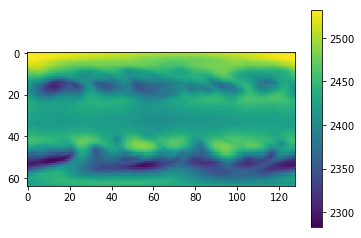

In [155]:
plt.imshow(p_diff[10, :, :, -5])
plt.colorbar()

In [225]:
x_data = aqua_file.SPDQ.values * np.rollaxis(np.diff(pressure.values, axis=0), 0, 2) * L_V / 9.81

In [226]:
x_data = np.sum(x_data, axis=1)[1:3]

In [227]:
y_data = aqua_file.LHFLX.values[:2] - aqua_file.PRECT.values[1:3] * 1e3 * L_V 

In [228]:
x_data.shape, y_data.shape

((2, 64, 128), (2, 64, 128))

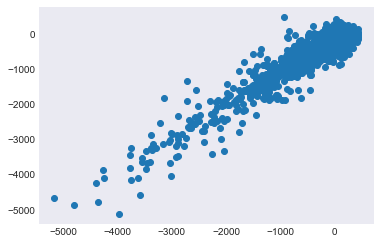

In [229]:
plt.scatter(np.ravel(y_data), np.ravel(x_data))

### Continue with budgets

In [140]:
p_diff.shape, targets_re[:, :, :, 21:42].shape

((48, 64, 128, 21), (2, 64, 128, 21))

In [187]:
spdq_vint = np.sum(targets_re[:, :, :, 21:42] * p_diff[:2], axis=-1) / 9.81
spdt_vint = np.sum(targets_re[:, :, :, :21] * p_diff[:2], axis=-1) / 9.81
precip = targets_re[:, :, :, -2] / (1e3*24*3600 * 1e-3) * L_V*1e3
evap = features_re_unnorm[:, :, :, -2]
sens = features_re_unnorm[:, :, :, -3]

In [188]:
spdq_preds_vint = np.sum(preds_re[:, :, :, 21:42] * p_diff[:2], axis=-1) / 9.81
spdt_preds_vint = np.sum(preds_re[:, :, :, :21] * p_diff[:2], axis=-1) / 9.81
precip_preds = preds_re[:, :, :, -2] / (1e3*24*3600 * 1e-3) * L_V*1e3

In [189]:
import seaborn as sns
sns.set_style('dark')

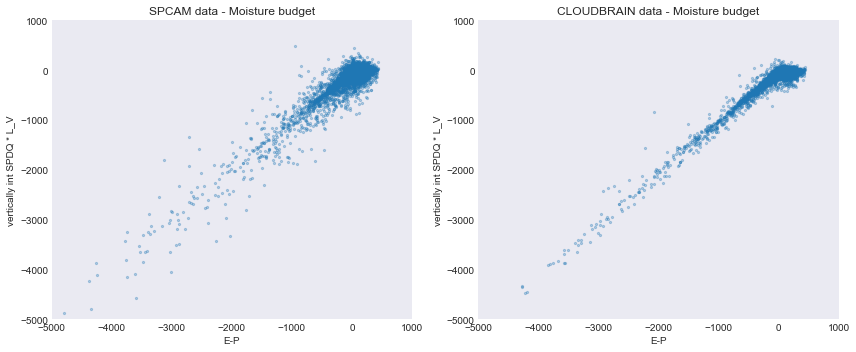

In [191]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i, name, p, s in zip(
    [0, 1],
    ['SPCAM', 'CLOUDBRAIN'],
    [precip, precip_preds],
    [spdq_vint, spdq_preds_vint],
):
    axes[i].scatter(evap-p, s, s=5, alpha=0.3)
    axes[i].set_xlabel('E-P')
    axes[i].set_ylabel('vertically int SPDQ * L_V')
    axes[i].set_title(name + ' data - Moisture budget')
    axes[i].set_xlim(-5000, 1000)
    axes[i].set_ylim(-5000, 1000)
plt.tight_layout()

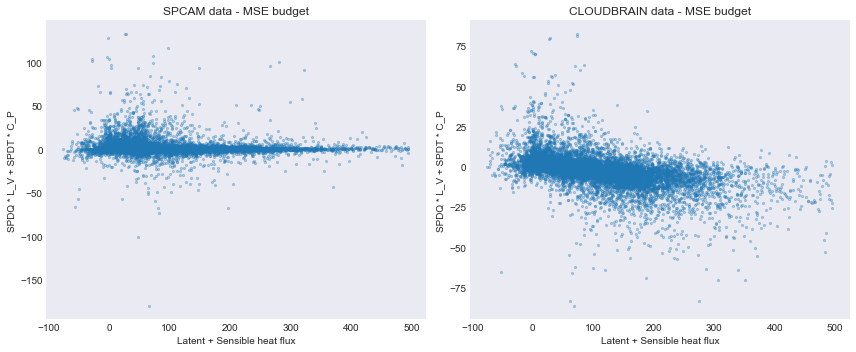

In [195]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i, name, p, sq, st in zip(
    [0, 1],
    ['SPCAM', 'CLOUDBRAIN'],
    [precip, precip_preds],
    [spdq_vint, spdq_preds_vint],
    [spdt_vint, spdt_preds_vint],
):
    axes[i].scatter(evap+sens, st+sq, s=5, alpha=0.3)
    axes[i].set_xlabel('Latent + Sensible heat flux')
    axes[i].set_ylabel('SPDQ * L_V + SPDT * C_P')
    axes[i].set_title(name + ' data - MSE budget')
plt.tight_layout()

## Create diagnostics routine

In [3]:
def np_rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred), axis=1))
def np_log_loss(y_true, y_pred):
    return np.mean(np.log(np_rmse(y_true, y_pred) + 1e-20) / np.log(10.))

In [4]:
def split_variables(x):
    """Hard-coded variable split for 21 lev"""
    spdt  = x[..., :21]
    spdq  = x[..., 21:42]
    qrl   = x[..., 42:63]
    qrs   = x[..., 63:84]
    prect = x[..., 84]
    flut  = x[..., 85]
    return spdt, spdq, qrl, qrs, prect, flut

In [5]:
def run_diagnostics(model_fn, valid_pref, norm_fn, verbose=False):
    # Load model
    model = keras.models.load_model(model_fn)
    if verbose: print(model.summary())
    
    # Load normalization file
    norm = xr.open_dataset(norm_fn).load()
    
    # Get data generator without shuffling!
    n_lon = 128; n_lat = 64; n_geo = n_lat * n_lon
    gen_obj = DataGenerator(
        data_dir, 
        valid_pref + '_features.nc', 
        valid_pref + '_targets.nc',
        shuffle=False, 
        batch_size=n_geo,
    )
    gen = gen_obj.return_generator()
    # Loop over chunks, get predictions compute scores
    sse = np.zeros((gen_obj.target_shape))   # Sum of squared errors [z]
    var_log_loss = np.zeros((6))
    log_loss = 0
    for t in tqdm(range(gen_obj.n_batches)):
        # Load features and targets
        tmp_features, tmp_targets = next(gen)
        # Get predictions
        tmp_preds = model.predict_on_batch(tmp_features)
        # Reshape to [time, lat, lon, lev]
        tmp_targets = tmp_targets.reshape((-1, n_lat, n_lon, tmp_targets.shape[-1]))
        tmp_preds = tmp_preds.reshape((-1, n_lat, n_lon, tmp_preds.shape[-1]))
        # Split by variable
        split_targets = split_variables(tmp_targets)
        split_preds = split_variables(tmp_preds)
        # Compute statistics
        sse += np.sum((tmp_targets - tmp_preds) ** 2, axis=(0, 1, 2))
        log_loss += np_log_loss(tmp_targets, tmp_preds)
        for i in range(6):
            var_log_loss[i] += np_log_loss(split_targets[i], split_preds[i])
    
    # Get average statistics
    mse = sse / (gen_obj.n_batches * n_geo)
    rel_mse = mse / norm.target_stds ** 2
    var_log_loss = var_log_loss / (gen_obj.n_batches)
    log_loss = log_loss / (gen_obj.n_batches)
    
    # Close open files
    norm.close()
    
    return rel_mse, mse, var_log_loss, log_loss

In [6]:
rel_mse, mse, var_log_loss, log_loss = run_diagnostics(
    './models/001_1year_noshuffle.h5', 
    'train_year0_month1', 
    data_dir + 'year0_norm.nc',
)

  0%|          | 0/1487 [00:00<?, ?it/s]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              90112     
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 86)                44118     
Total params: 1,971,286
Trainable params: 1,971,286
Non-trainable params: 0
_________________________________________________________________
None
Generator will have 12181504 samples in 1487 batches
Features have shape 87; targets have shape 86


  0%|          | 3/1487 [00:00<06:09,  4.02it/s]

[0.014610336, 0.036225501, -1.5493344, 3353.4839, 1461.3521, 0.56422865, 2441.1782, 0.40137428]
-1.54933
[0.0089338878, 0.026401246, -1.7360892, 2521.9392, 878.14423, 0.65179801, 1627.8676, 0.46055549]
-1.73609
[0.0077598221, 0.022389371, -1.8339155, 4508.9136, 741.14374, 0.83562696, 3240.1445, 0.77126217]
-1.83392
[0.010520043, 0.032345027, -1.7943292, 11647.318, 2604.6553, 0.77637297, 8975.8262, 0.70981443]
-1.79433


  1%|          | 8/1487 [00:00<03:04,  8.01it/s]

[0.013575014, 0.042580657, -1.679002, 13685.122, 3675.9011, 0.73139435, 10117.979, 0.6366961]
-1.679
[0.015156317, 0.046976451, -1.5989712, 13018.305, 3733.0352, 0.71324718, 9445.3564, 0.60477561]
-1.59897
[0.016104098, 0.047987659, -1.5679353, 12135.98, 3803.9612, 0.68655509, 9015.2969, 0.57805479]
-1.56794
[0.016404456, 0.046746362, -1.5629466, 10719.761, 3598.4556, 0.6643157, 8237.9434, 0.56318521]
-1.56295


  1%|          | 12/1487 [00:01<02:28,  9.95it/s]

[0.016118279, 0.044491563, -1.5717118, 9450.2422, 3255.6321, 0.65549749, 7328.0981, 0.55573303]
-1.57171
[0.015540639, 0.041934229, -1.5829502, 8305.1045, 2686.4314, 0.67653251, 6459.0112, 0.5840801]
-1.58295
[0.015212343, 0.040549371, -1.5897846, 7734.125, 2439.948, 0.68452179, 5949.543, 0.58989322]
-1.58978
[0.014884669, 0.039431348, -1.5975612, 7502.6196, 2280.8328, 0.69599515, 5731.7681, 0.6020717]
-1.59756


  1%|          | 15/1487 [00:01<02:12, 11.08it/s]

[0.014719637, 0.038765058, -1.6008637, 7348.7544, 2199.7866, 0.70065856, 5583.0425, 0.60598785]
-1.60086
[0.014558013, 0.038030136, -1.6074016, 7109.3755, 2095.0457, 0.70531225, 5365.6782, 0.6095469]
-1.6074
[0.014470221, 0.037770204, -1.6098697, 7019.043, 2033.7814, 0.71024805, 5257.4927, 0.61316514]
-1.60987
[0.014362871, 0.037435453, -1.6140952, 7019.7993, 2033.9866, 0.71025002, 5259.7769, 0.61329412]
-1.6141


  1%|▏         | 19/1487 [00:01<02:00, 12.20it/s]

[0.014268124, 0.037161149, -1.6169729, 6911.5049, 1978.7649, 0.71369982, 5145.0054, 0.61540079]
-1.61697
[0.014453055, 0.037753973, -1.6158217, 7132.7915, 2124.8049, 0.70210755, 5349.6621, 0.60281515]
-1.61582
[0.014320964, 0.037316278, -1.6184807, 7133.8369, 2041.9159, 0.71377027, 5321.6001, 0.61629665]
-1.61848
[0.014447755, 0.037690241, -1.6166722, 7249.6704, 2084.48, 0.71247244, 5386.2578, 0.61300033]
-1.61667


  2%|▏         | 23/1487 [00:01<01:55, 12.73it/s]

[0.014484572, 0.037814241, -1.6155105, 7161.752, 2100.5315, 0.70670146, 5319.3081, 0.6051119]
-1.61551
[0.01468334, 0.038309209, -1.6102244, 7337.291, 2155.3469, 0.70624757, 5460.832, 0.60530794]
-1.61022
[0.014789106, 0.038548298, -1.6065218, 7281.9424, 2197.7666, 0.6981895, 5448.4785, 0.59662747]
-1.60652
[0.014704678, 0.038323216, -1.6063385, 7282.9785, 2150.4614, 0.70472777, 5411.5591, 0.60261703]
-1.60634


  2%|▏         | 28/1487 [00:02<01:47, 13.61it/s]

[0.014615234, 0.038301248, -1.6085261, 7257.4868, 2153.3201, 0.70329672, 5407.7397, 0.60180771]
-1.60853
[0.01471872, 0.038643267, -1.604583, 7270.5918, 2177.0586, 0.70056653, 5421.6528, 0.59845114]
-1.60458
[0.014619179, 0.038368244, -1.6050622, 7204.8604, 2141.5923, 0.70275724, 5360.1143, 0.60045773]
-1.60506
[0.014542386, 0.038149938, -1.6039246, 7264.2651, 2079.2822, 0.71376562, 5374.0376, 0.61308753]
-1.60392


  2%|▏         | 30/1487 [00:02<01:44, 13.89it/s]

[0.014445889, 0.037905324, -1.6044797, 7103.5703, 2054.4023, 0.71079302, 5226.1543, 0.6068998]
-1.60448
[0.014639473, 0.038618539, -1.6003765, 7321.6191, 2148.0085, 0.70662111, 5425.2559, 0.60407239]
-1.60038
[0.014574419, 0.038340084, -1.6013105, 7251.7817, 2126.2576, 0.70679516, 5376.7681, 0.60454726]
-1.60131
[0.01470207, 0.038696475, -1.5996315, 7261.8379, 2197.3599, 0.69740999, 5392.3931, 0.59250748]
-1.59963


  2%|▏         | 36/1487 [00:02<01:39, 14.66it/s]

[0.0145644, 0.03820841, -1.6015559, 7232.8057, 2098.4902, 0.70986497, 5349.3354, 0.60771012]
-1.60156
[0.014722805, 0.038702104, -1.5976257, 7243.2539, 2172.5054, 0.70006502, 5364.0156, 0.59498525]
-1.59763
[0.014667993, 0.038497064, -1.5985845, 7168.1919, 2135.353, 0.70210719, 5288.8096, 0.59625071]
-1.59858
[0.014512845, 0.038112927, -1.6021229, 7082.6631, 2045.9547, 0.71113199, 5194.7681, 0.60615087]
-1.60212


  3%|▎         | 40/1487 [00:02<01:36, 15.03it/s]

[0.014564599, 0.038185537, -1.6010288, 7135.543, 2087.9177, 0.70739186, 5247.4688, 0.60210955]
-1.60103
[0.014682711, 0.03855649, -1.5975734, 7166.0796, 2121.4355, 0.70396149, 5265.7578, 0.59712625]
-1.59757
[0.014677519, 0.03853707, -1.5964488, 7114.2847, 2129.4639, 0.70067775, 5245.1968, 0.59401643]
-1.59645
[0.014742439, 0.038647301, -1.5959814, 7197.9326, 2143.3533, 0.70222652, 5285.1411, 0.59445679]
-1.59598


  3%|▎         | 44/1487 [00:02<01:34, 15.34it/s]

[0.014780613, 0.038631897, -1.5955592, 7091.4268, 2144.1194, 0.69764626, 5237.6597, 0.59063411]
-1.59556
[0.014598427, 0.03813453, -1.5971508, 7012.1147, 2045.3246, 0.70831561, 5143.9448, 0.60238206]
-1.59715
[0.014722477, 0.038500194, -1.5963843, 7133.3857, 2118.4089, 0.70302898, 5238.5557, 0.59561205]
-1.59638
[0.014556622, 0.037974015, -1.5976999, 6981.9531, 2027.9088, 0.7095499, 5111.4966, 0.60326517]
-1.5977


  3%|▎         | 48/1487 [00:03<01:32, 15.64it/s]

[0.014843063, 0.03874208, -1.5932326, 7180.6499, 2168.4761, 0.69801116, 5287.2983, 0.58987069]
-1.59323
[0.014864631, 0.038827635, -1.5935813, 7261.6182, 2193.0901, 0.69798875, 5369.3047, 0.59155047]
-1.59358
[0.014787141, 0.038601525, -1.5925043, 7062.6523, 2103.1482, 0.70221555, 5192.3823, 0.59495509]
-1.5925
[0.014895099, 0.038872283, -1.5897617, 7030.0615, 2154.6257, 0.69351256, 5179.3535, 0.58399713]
-1.58976


  3%|▎         | 51/1487 [00:03<01:30, 15.84it/s]

[0.014739295, 0.038651466, -1.5920546, 6989.1484, 2117.895, 0.6969738, 5140.5767, 0.58800435]
-1.59205
[0.014625603, 0.038391076, -1.5966684, 7011.3608, 2079.0498, 0.70347416, 5147.9277, 0.59613848]
-1.59667
[0.014501397, 0.037964556, -1.597791, 7026.7251, 2061.0015, 0.70669103, 5141.5679, 0.59914923]
-1.59779
[0.014670582, 0.038559683, -1.5934589, 7017.0479, 2123.2578, 0.6974144, 5145.1748, 0.58733028]
-1.59346
[0.014666497, 0.038560919, -1.5919447, 7022.0103, 2104.0613, 0.70036197, 5146.8066, 0.59119093]
-1.59194


  4%|▍         | 57/1487 [00:03<01:28, 16.21it/s]

[0.014719889, 0.038740013, -1.590852, 7093.5, 2147.4062, 0.69727123, 5213.6802, 0.58812082]
-1.59085
[0.014790517, 0.038966767, -1.5905927, 7196.2954, 2170.4336, 0.69839573, 5286.2275, 0.58941734]
-1.59059
[0.014818239, 0.039010942, -1.5882139, 7092.3018, 2141.4121, 0.69806528, 5236.9775, 0.59109771]
-1.58821
[0.014715452, 0.038627349, -1.5927429, 7005.4941, 2122.0767, 0.69708395, 5150.0669, 0.58795166]
-1.59274


[0.014764229, 0.038720619, -1.591386, 6988.9067, 2154.4976, 0.69172609, 5147.8525, 0.58147645]
-1.59139


KeyboardInterrupt: 

In [9]:
log_loss

-2.1694478058702766

In [10]:
var_log_loss

array([-1.71778759, -1.7279496 , -2.19701767, -2.92550602, -2.67726033,
       -3.96177311])

In [11]:
128 * 64

8192

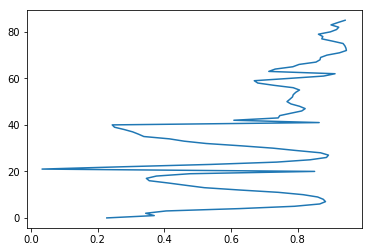

In [9]:
plt.plot(1 - rel_mse, range(86))

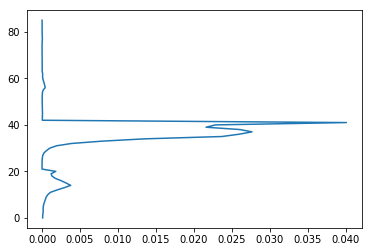

In [10]:
plt.plot(mse, range(86))

In [10]:
norm = xr.open_dataset(data_dir + 'year0_norm.nc')

In [11]:
norm.target_names

<xarray.DataArray 'target_names' (target_lev: 86)>
array(['SPDT_lev09', 'SPDT_lev10', 'SPDT_lev11', 'SPDT_lev12', 'SPDT_lev13',
       'SPDT_lev14', 'SPDT_lev15', 'SPDT_lev16', 'SPDT_lev17', 'SPDT_lev18',
       'SPDT_lev19', 'SPDT_lev20', 'SPDT_lev21', 'SPDT_lev22', 'SPDT_lev23',
       'SPDT_lev24', 'SPDT_lev25', 'SPDT_lev26', 'SPDT_lev27', 'SPDT_lev28',
       'SPDT_lev29', 'SPDQ_lev09', 'SPDQ_lev10', 'SPDQ_lev11', 'SPDQ_lev12',
       'SPDQ_lev13', 'SPDQ_lev14', 'SPDQ_lev15', 'SPDQ_lev16', 'SPDQ_lev17',
       'SPDQ_lev18', 'SPDQ_lev19', 'SPDQ_lev20', 'SPDQ_lev21', 'SPDQ_lev22',
       'SPDQ_lev23', 'SPDQ_lev24', 'SPDQ_lev25', 'SPDQ_lev26', 'SPDQ_lev27',
       'SPDQ_lev28', 'SPDQ_lev29', 'QRL_lev09', 'QRL_lev10', 'QRL_lev11',
       'QRL_lev12', 'QRL_lev13', 'QRL_lev14', 'QRL_lev15', 'QRL_lev16',
       'QRL_lev17', 'QRL_lev18', 'QRL_lev19', 'QRL_lev20', 'QRL_lev21',
       'QRL_lev22', 'QRL_lev23', 'QRL_lev24', 'QRL_lev25', 'QRL_lev26',
       'QRL_lev27', 'QRL_lev28', 'QRL_lev29

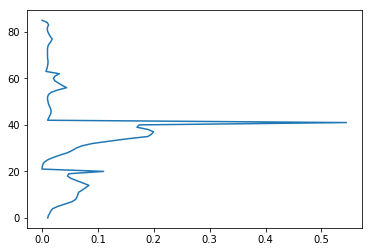

In [19]:
plt.plot(norm.target_stds, range(86))

In [13]:
np.mean(1-rel_mse)

<xarray.DataArray 'target_stds' ()>
array(0.6910081693082578)

In [78]:
np.mean(1-split_variables(rel_mse)[5])

<xarray.DataArray 'target_stds' ()>
array(0.940715001144983)
Coordinates:
    target_lev  int64 85

### Plot random samples

In [12]:
import utils; from utils import *

In [13]:
feature_names = ['TAP', 'QAP', 'dTdt_adiabatic', 'dQdt_adiabatic', 'SHFLX', 'LHFLX', 'SOLIN']
target_names = ['SPDT', 'SPDQ', 'QRL', 'QRS', 'PRECT', 'FLUT']

In [14]:
n_lon = 128; n_lat = 64; n_geo = n_lat * n_lon

In [15]:
# Get some predictions
valid_targets = h5py.File(data_dir + 'valid_year1_targets.nc', 'r')
valid_features = h5py.File(data_dir + 'valid_year1_features.nc', 'r')

In [17]:
sample_targets = valid_targets['targets'][:3*n_geo, :]
sample_features = valid_features['features'][:3*n_geo, :]

In [10]:
model = keras.models.load_model('./models/002_1year_shuffle.h5')

In [18]:
preds = model.predict(sample_features)

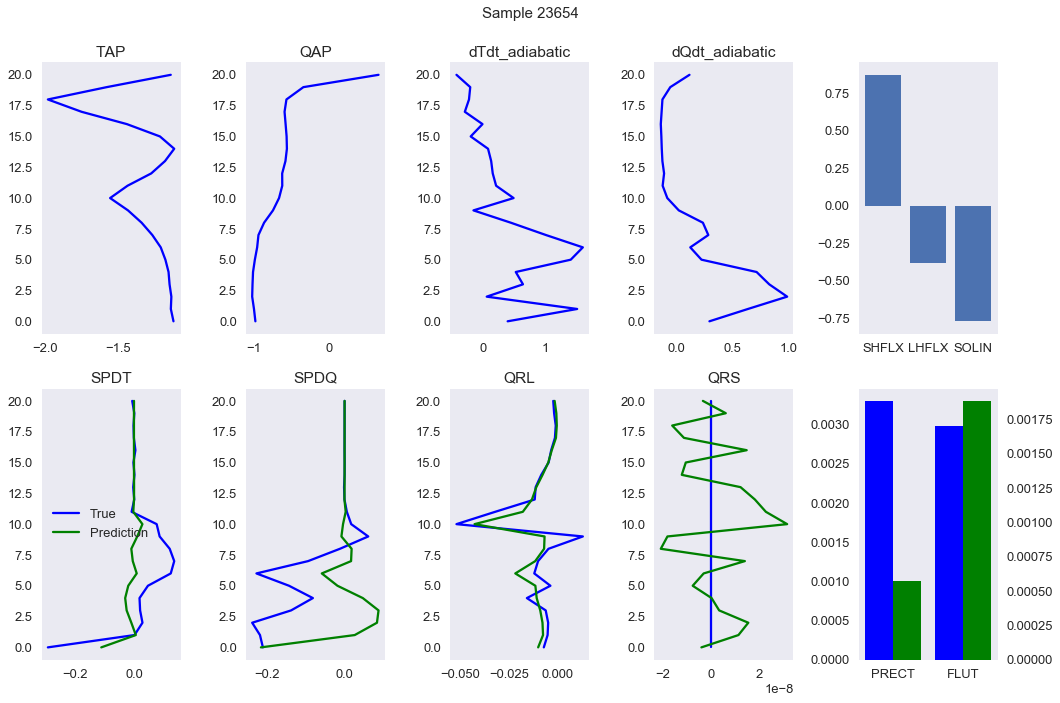

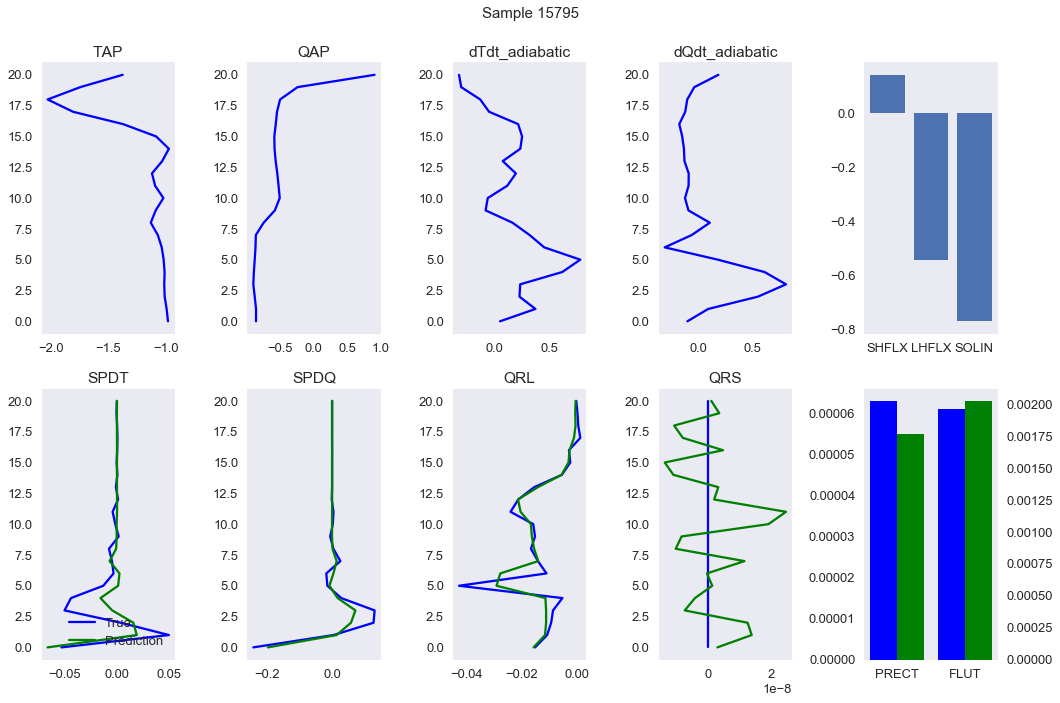

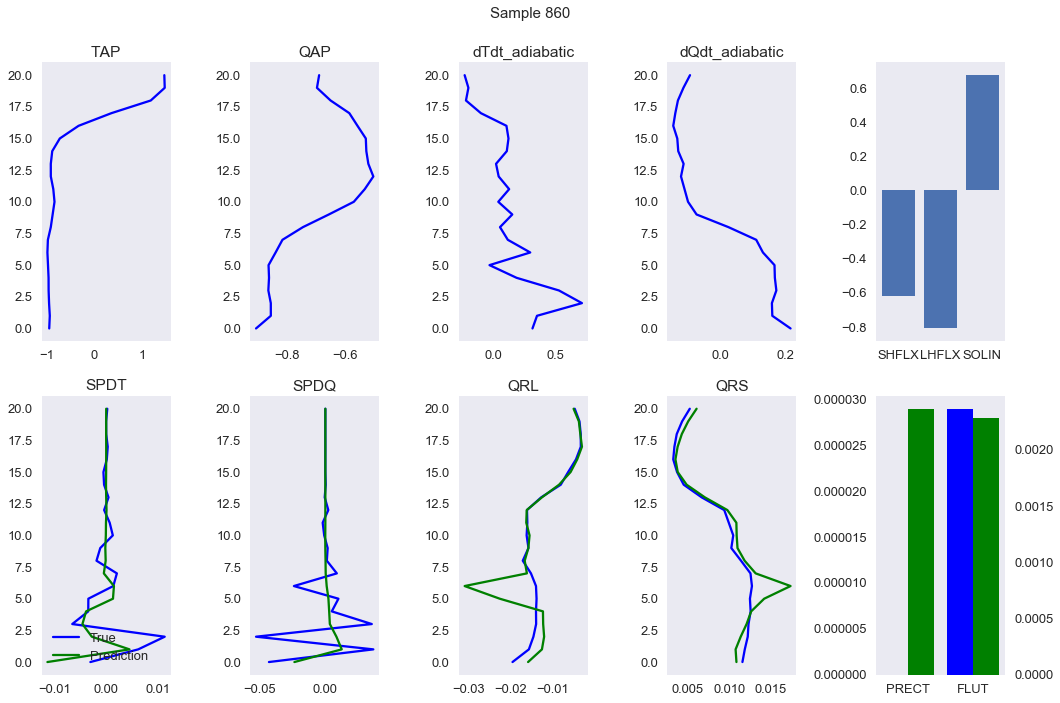

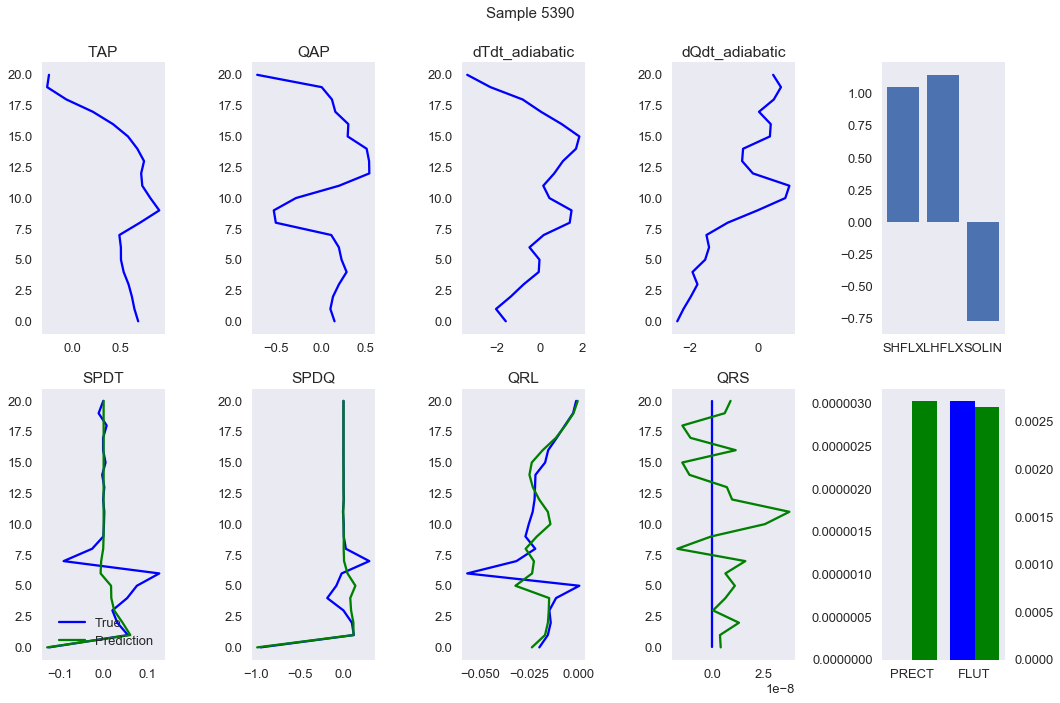

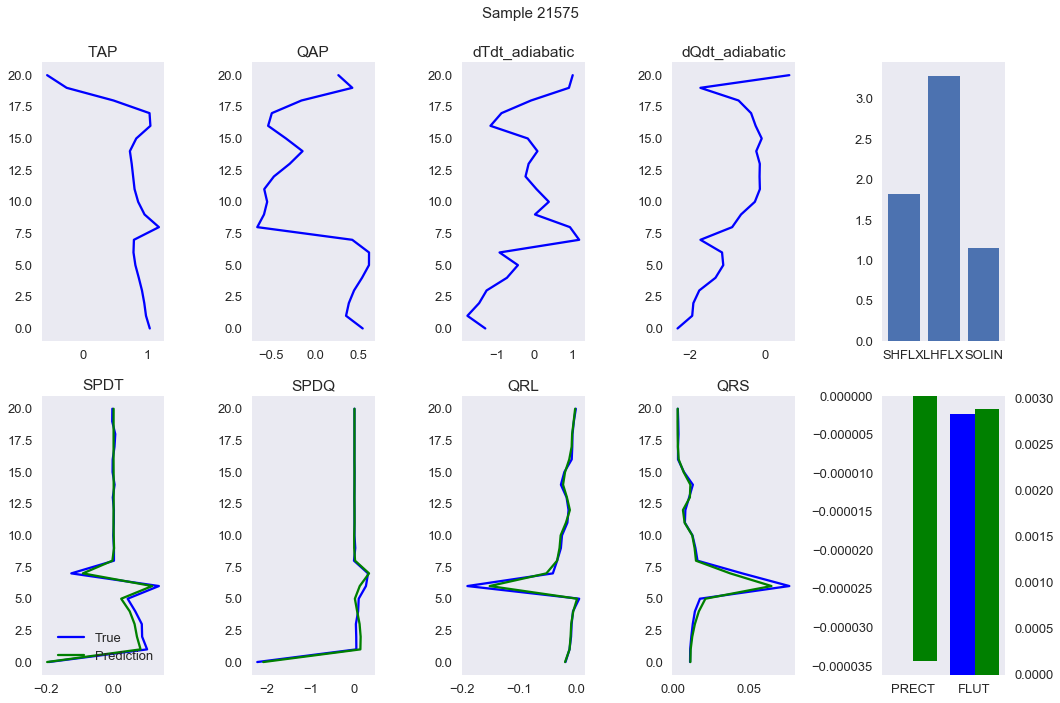

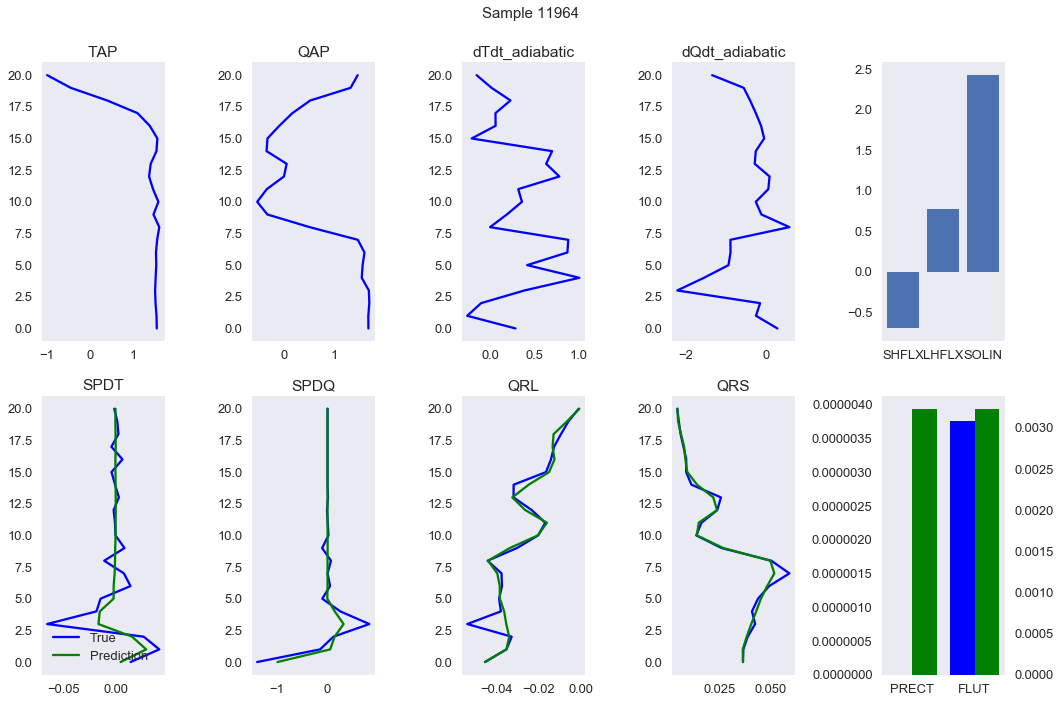

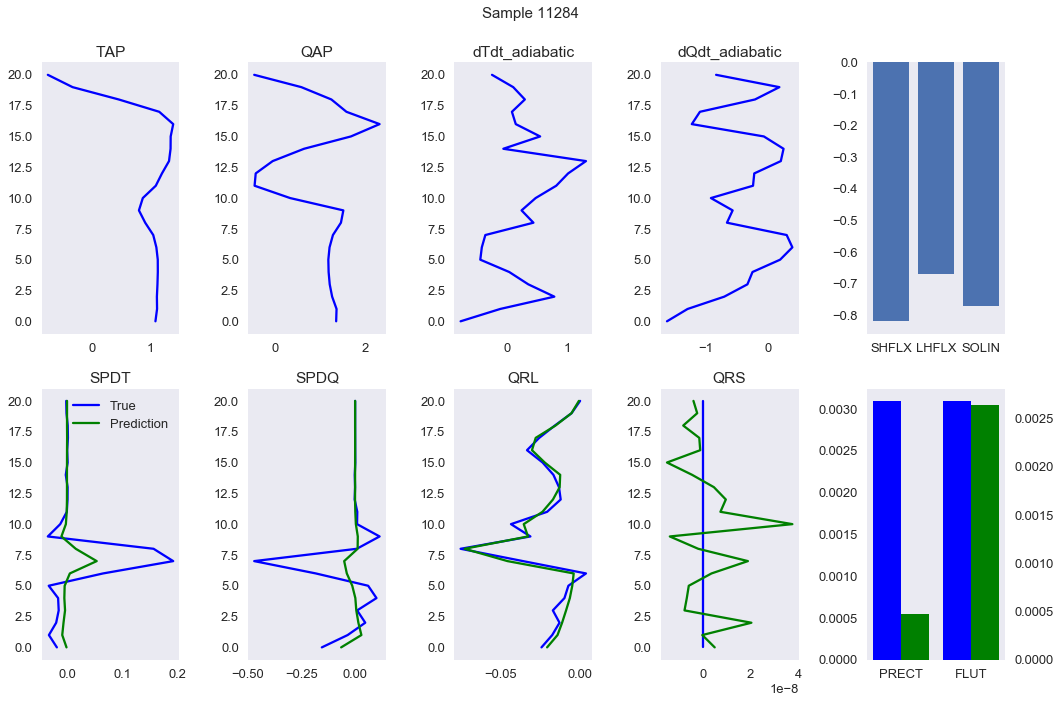

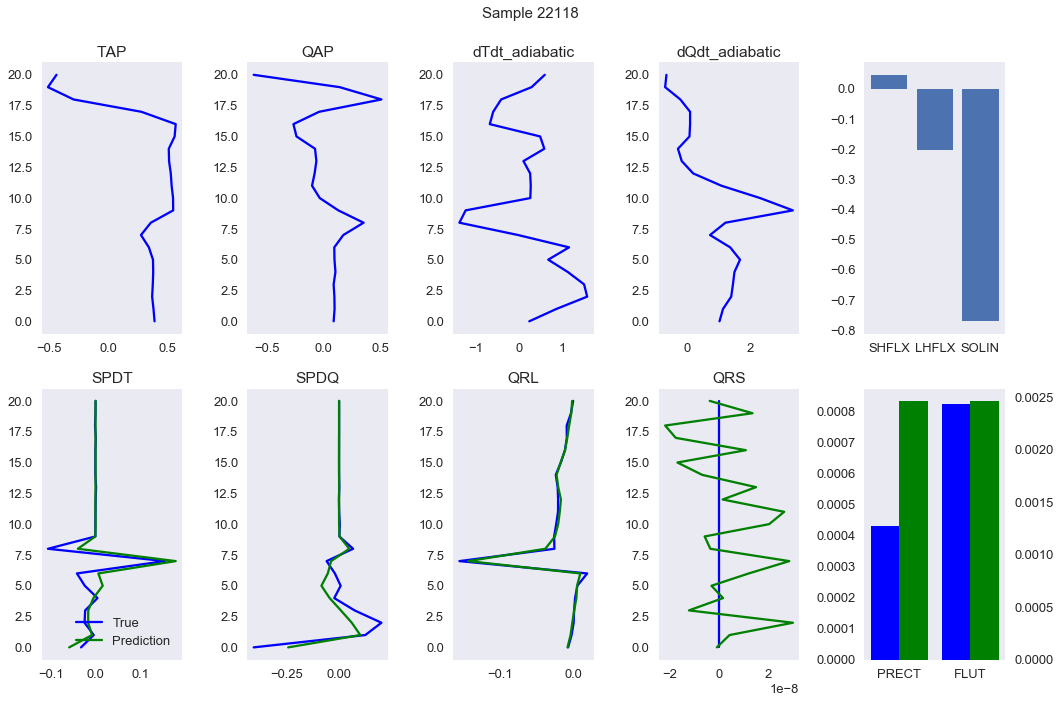

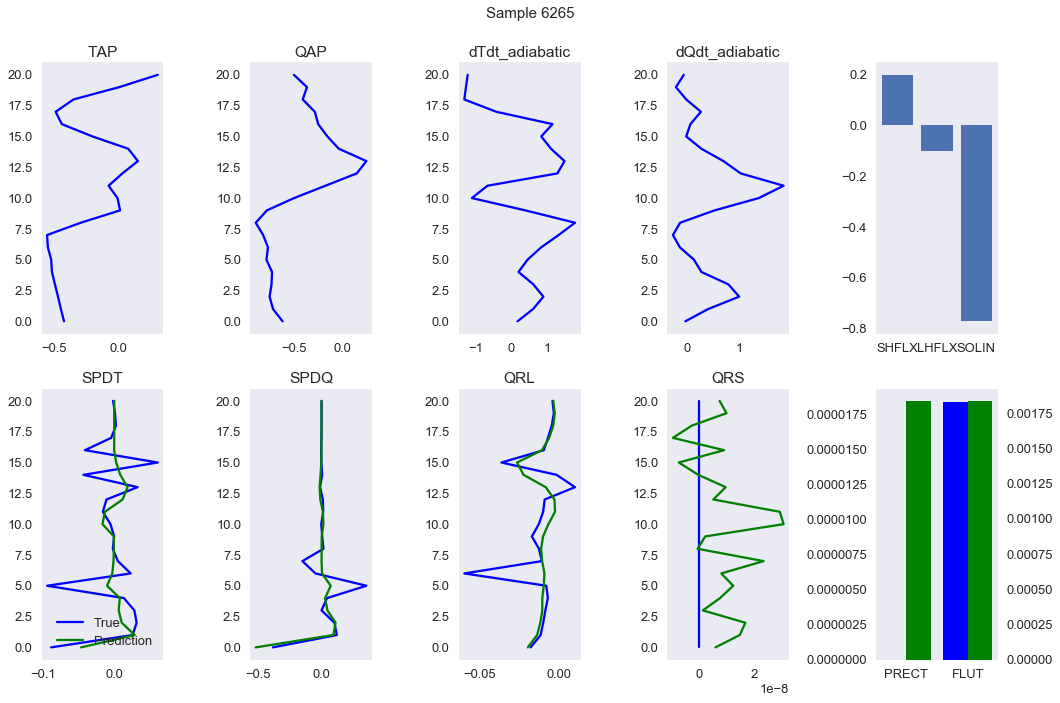

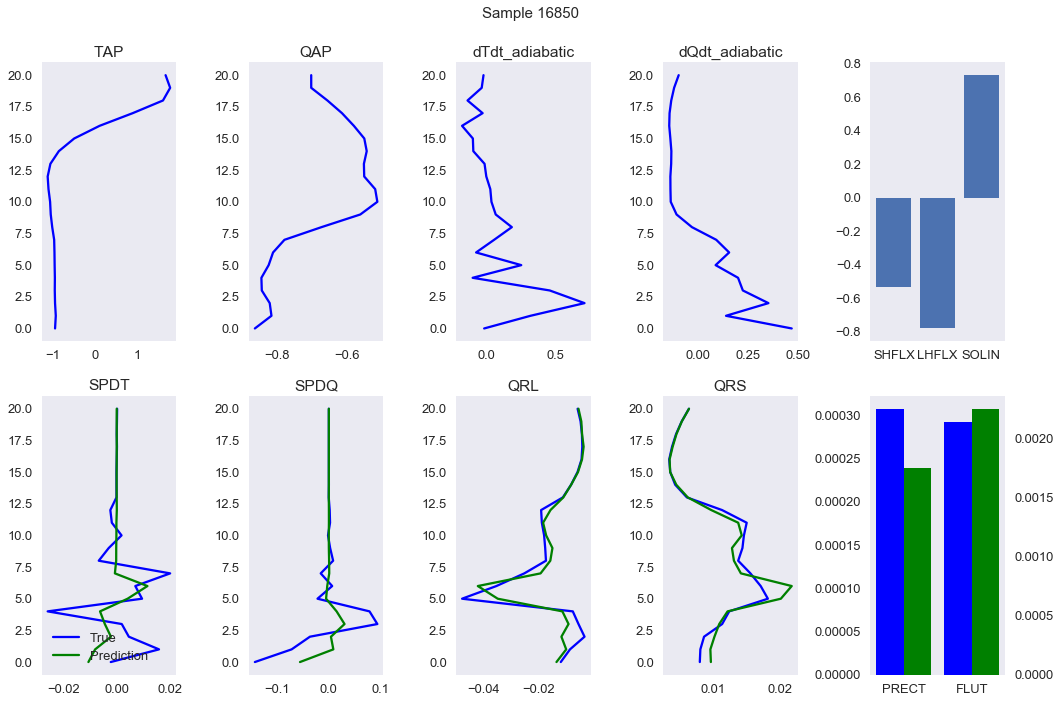

In [19]:
for i in list(np.random.randint(0, preds.shape[0], 10)):
    vis_features_targets_from_pred2(
        sample_features, 
        sample_targets, 
        preds,
        i, 
        feature_names, 
        target_names,
    )

In [32]:
model_log = keras.models.load_model('./models/015_1year_log_loss.h5')
preds_log = model_log.predict(sample_features)

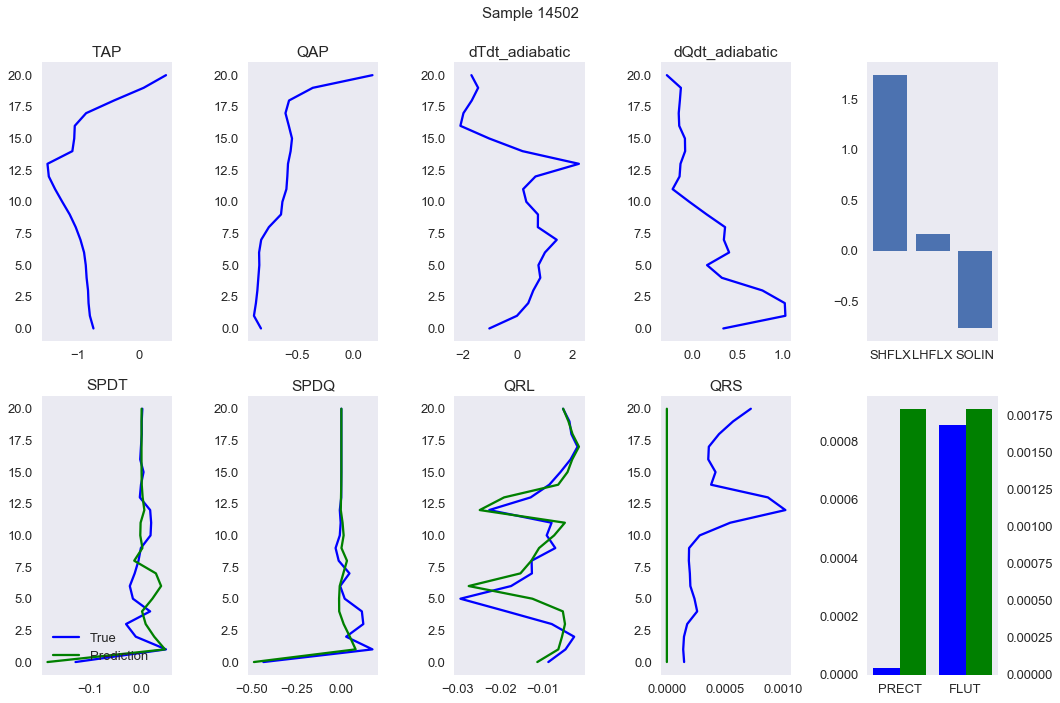

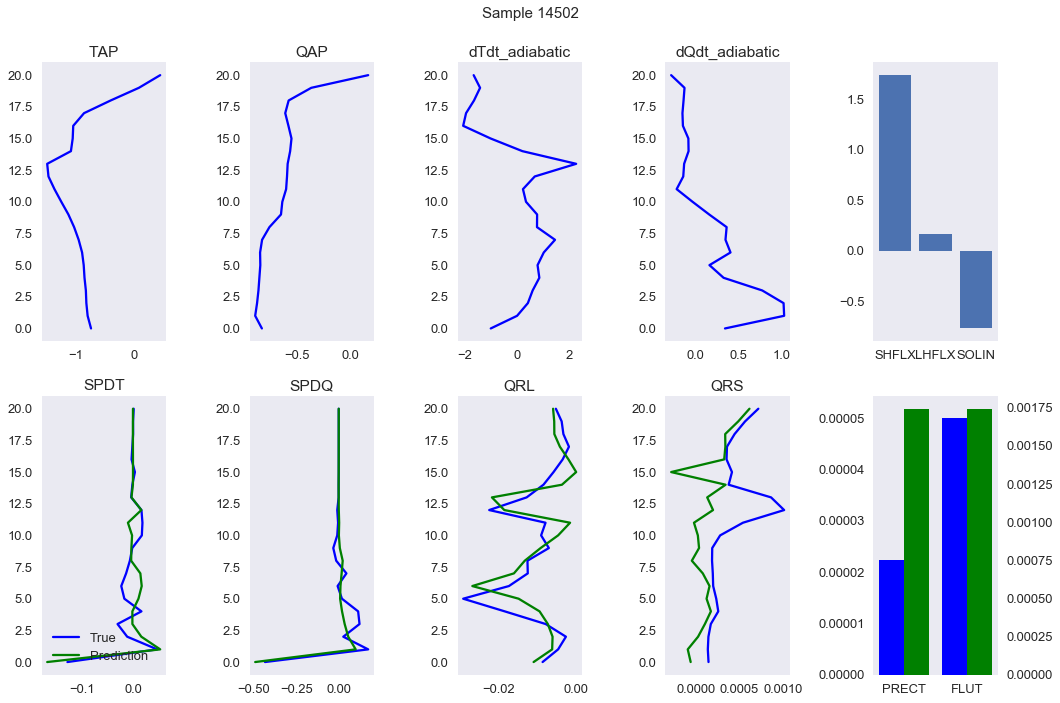

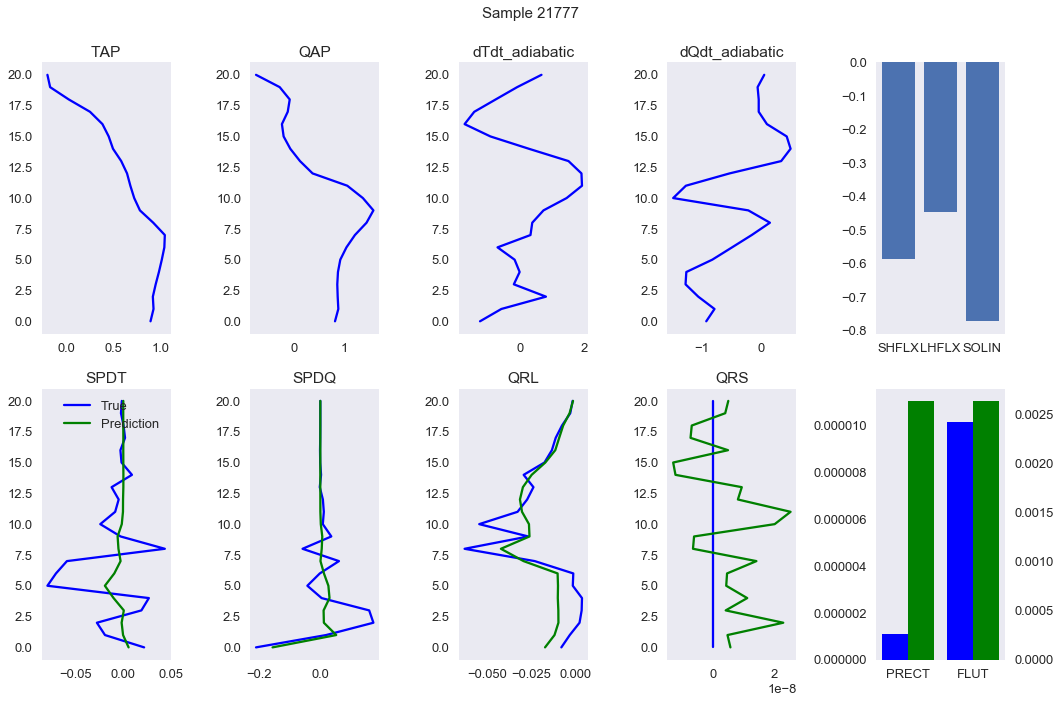

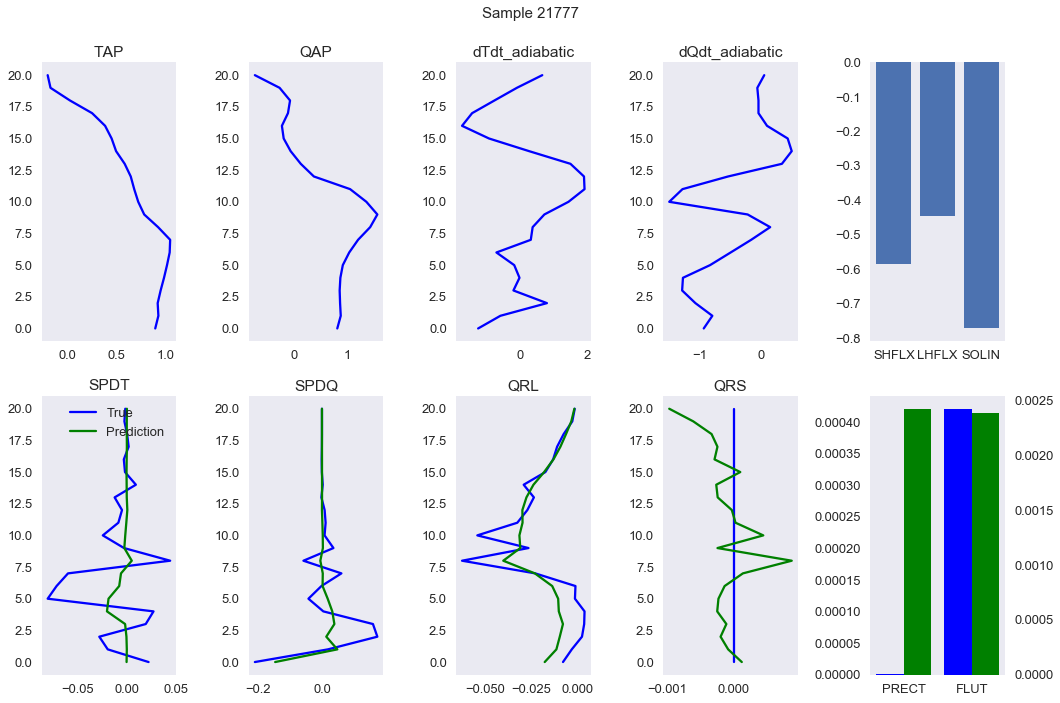

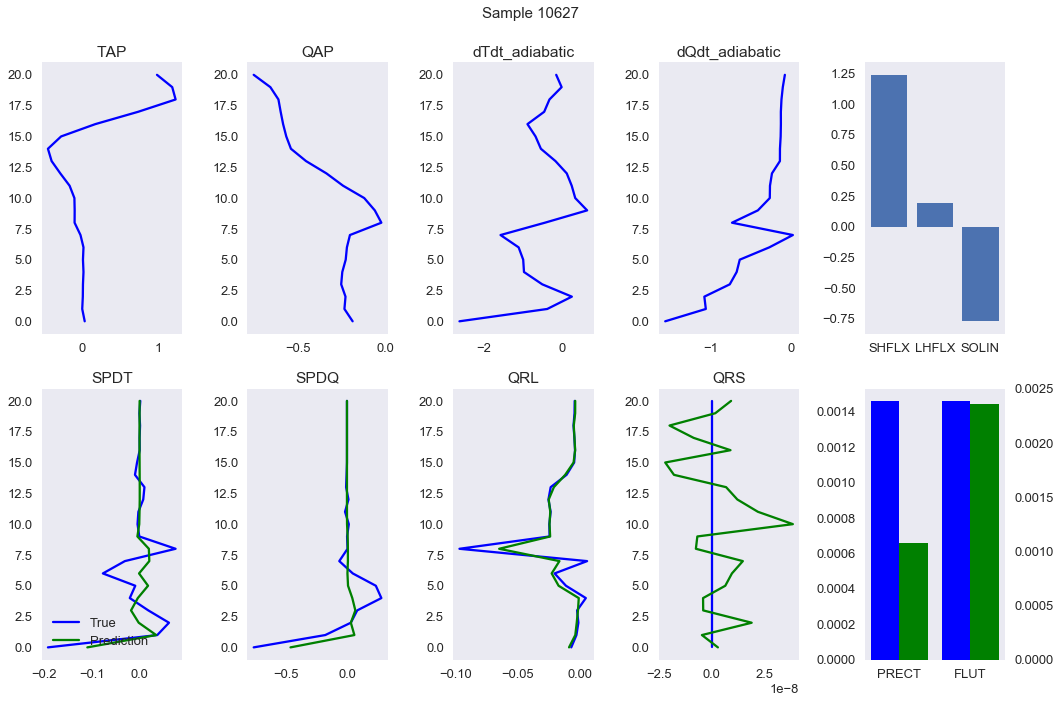

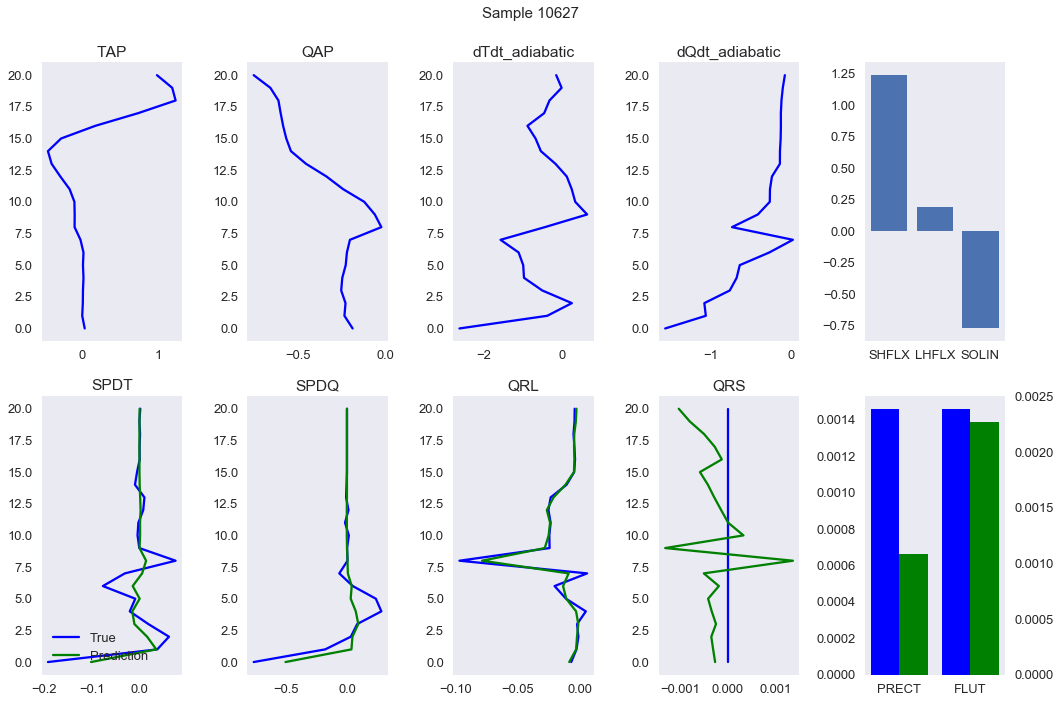

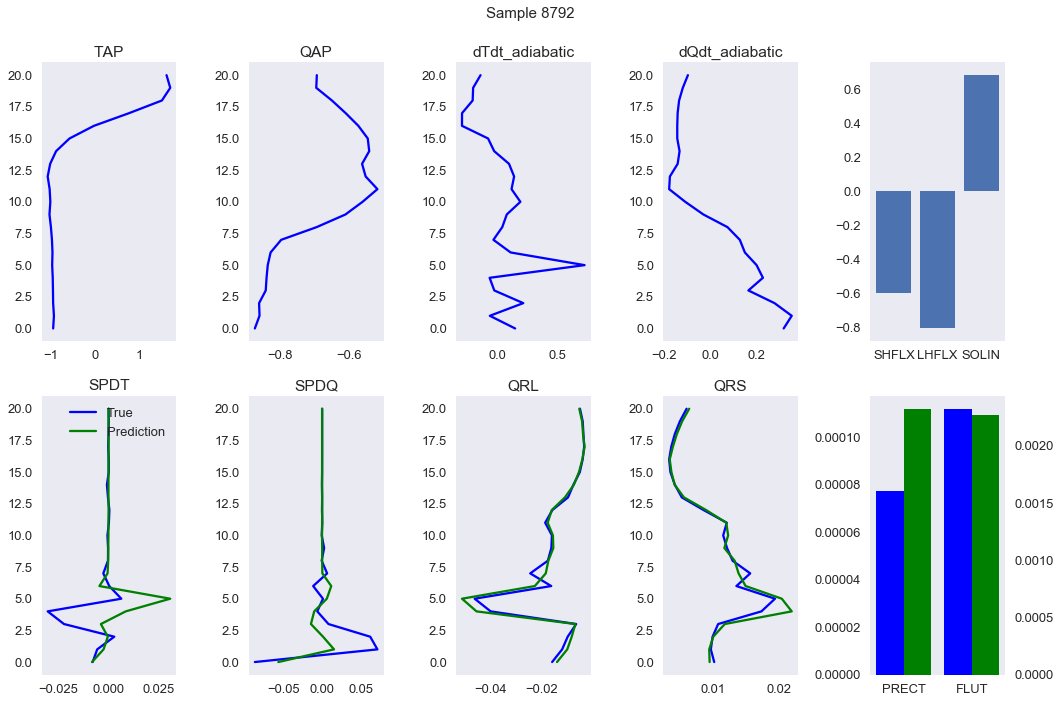

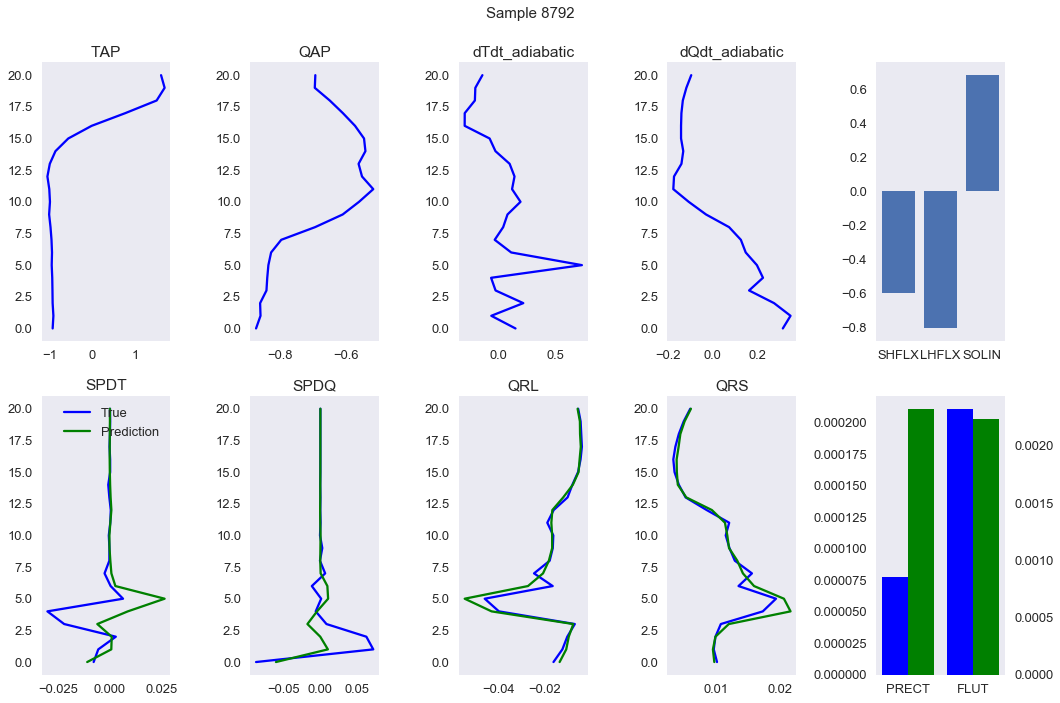

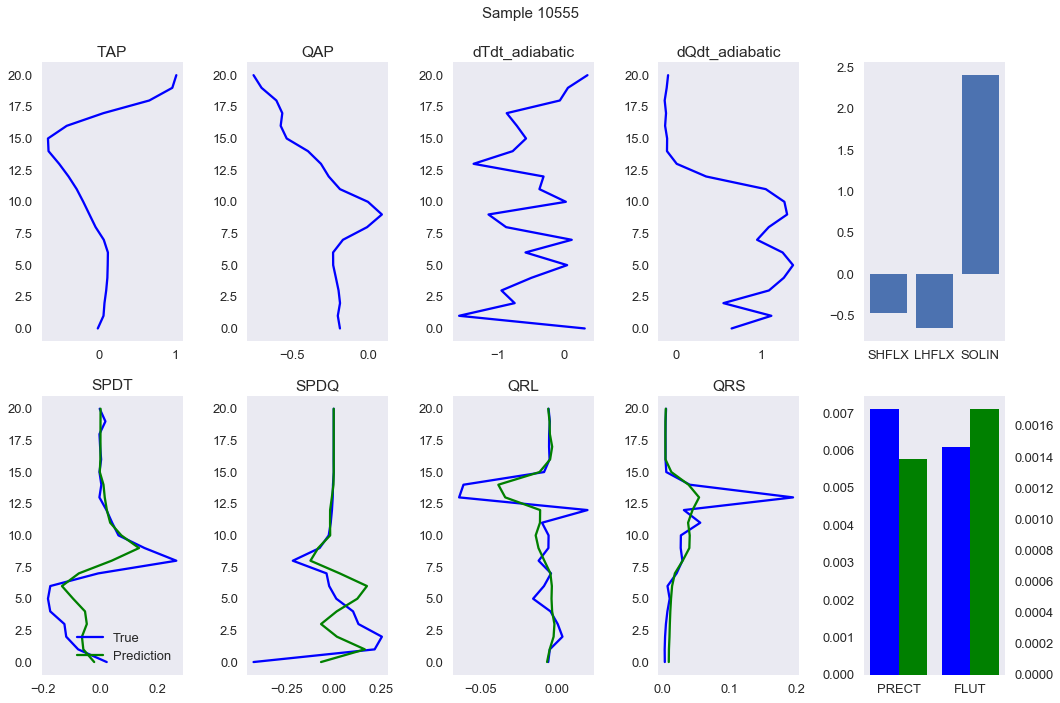

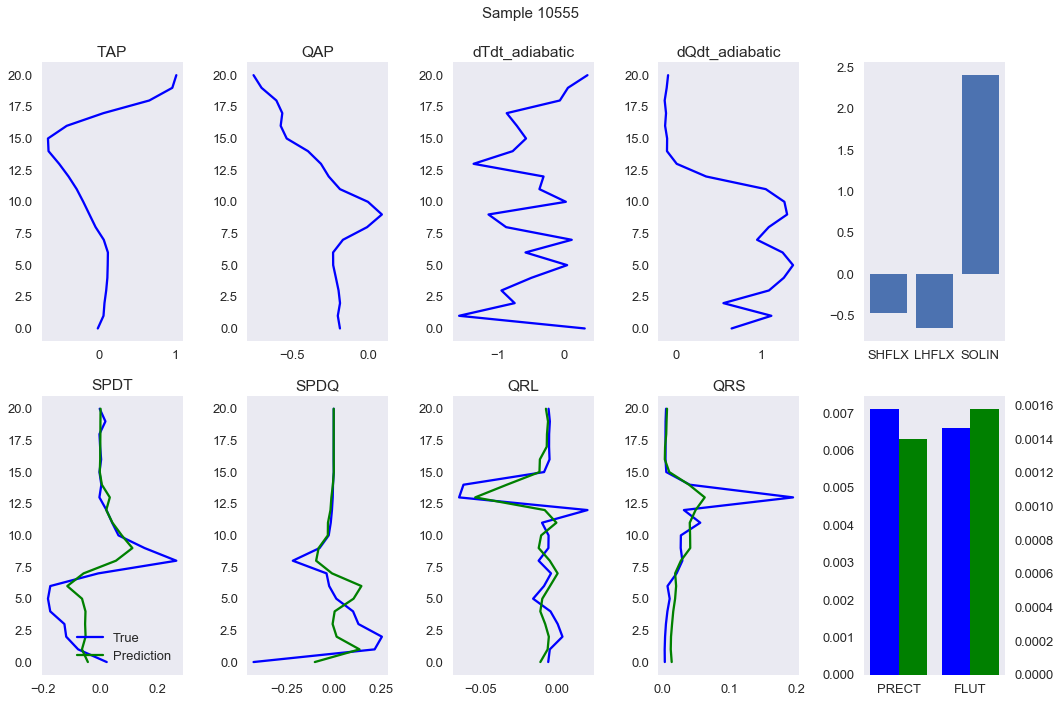

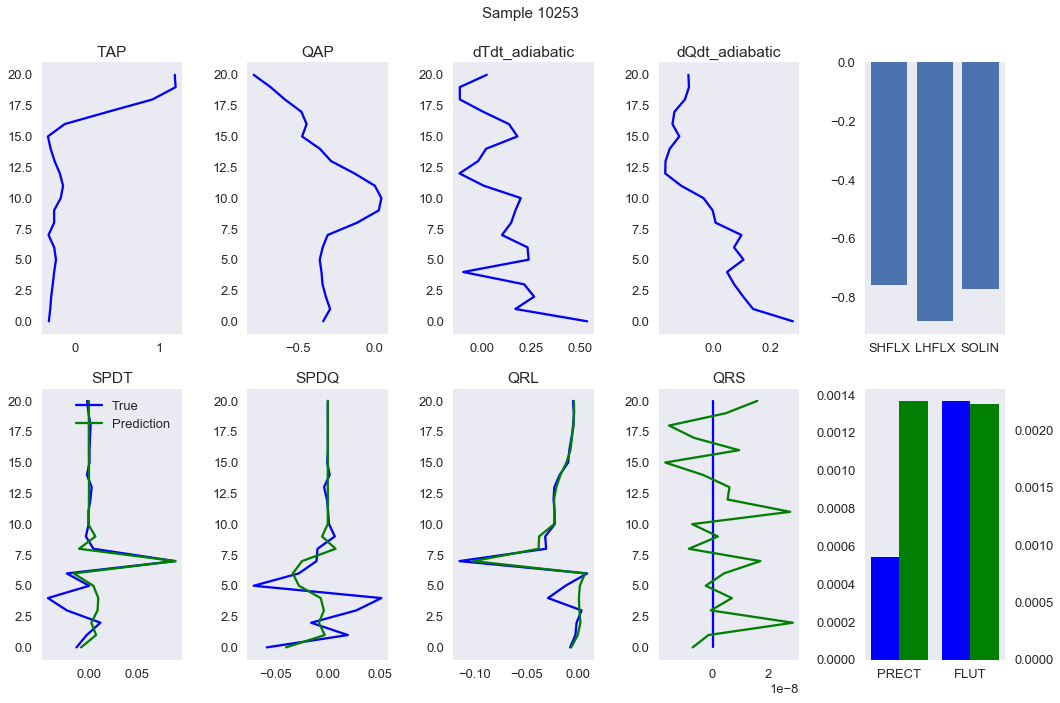

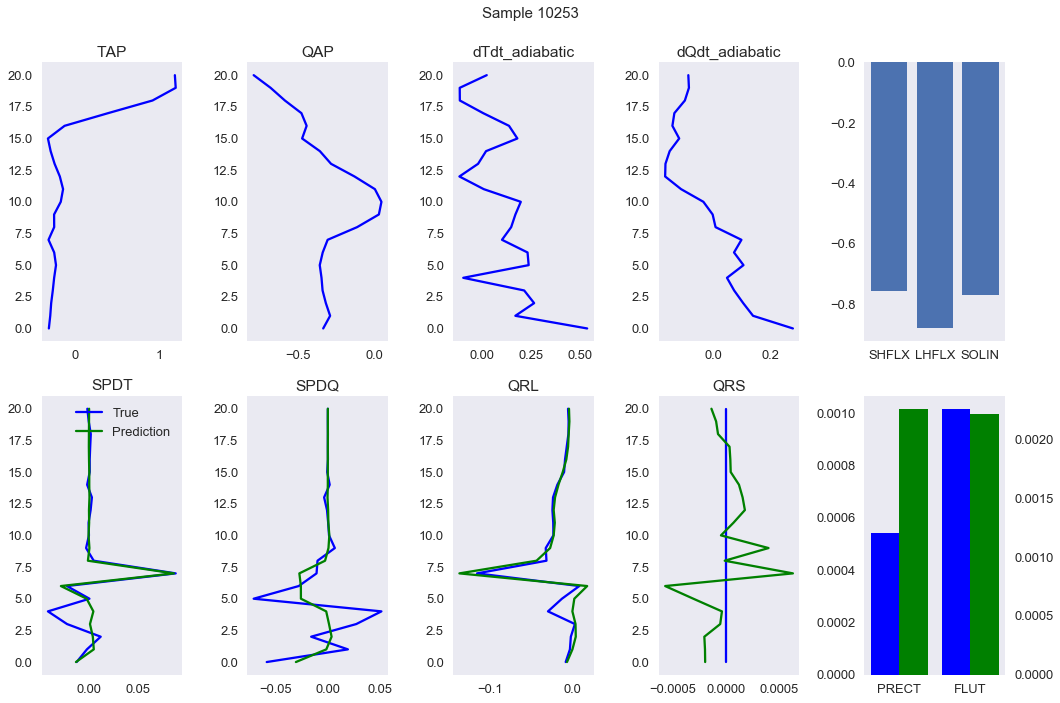

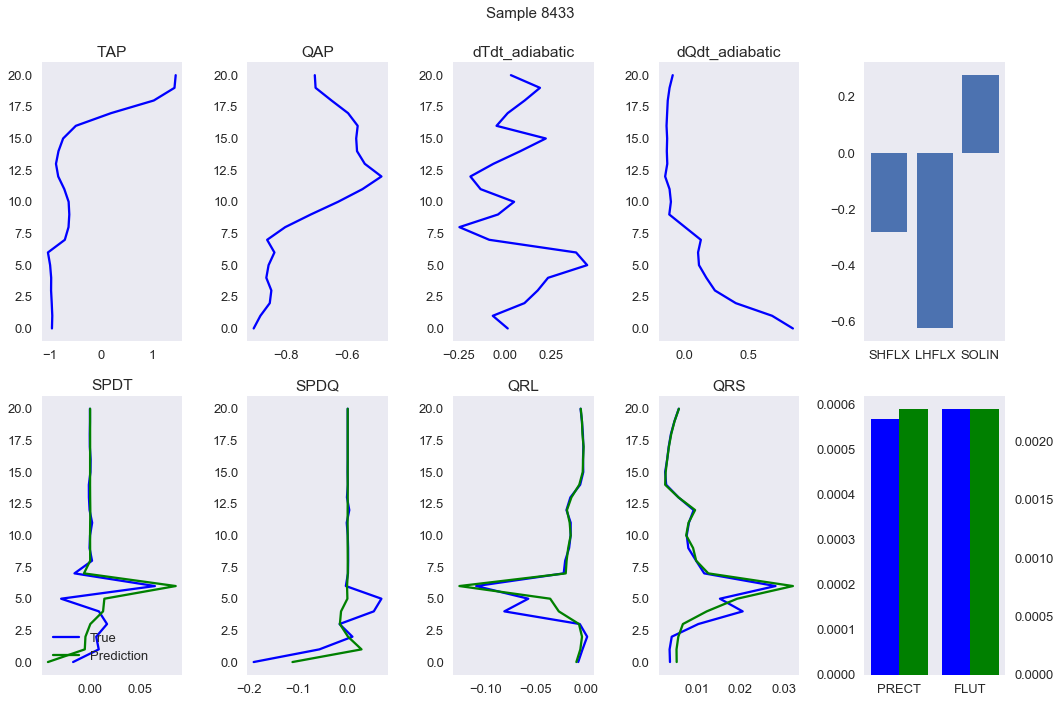

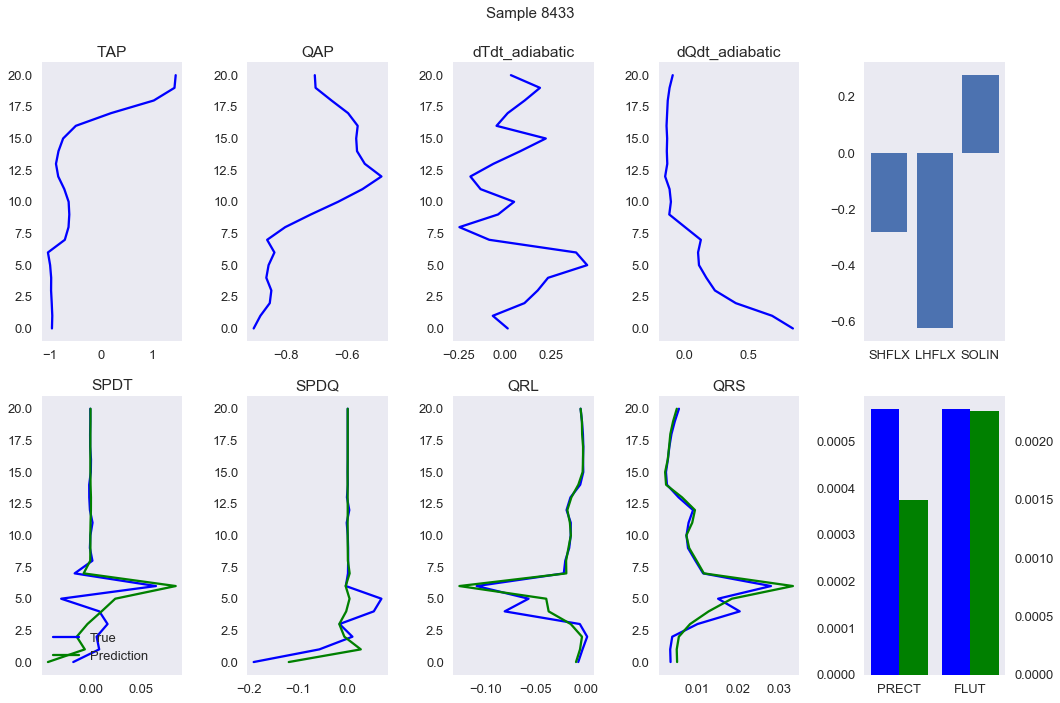

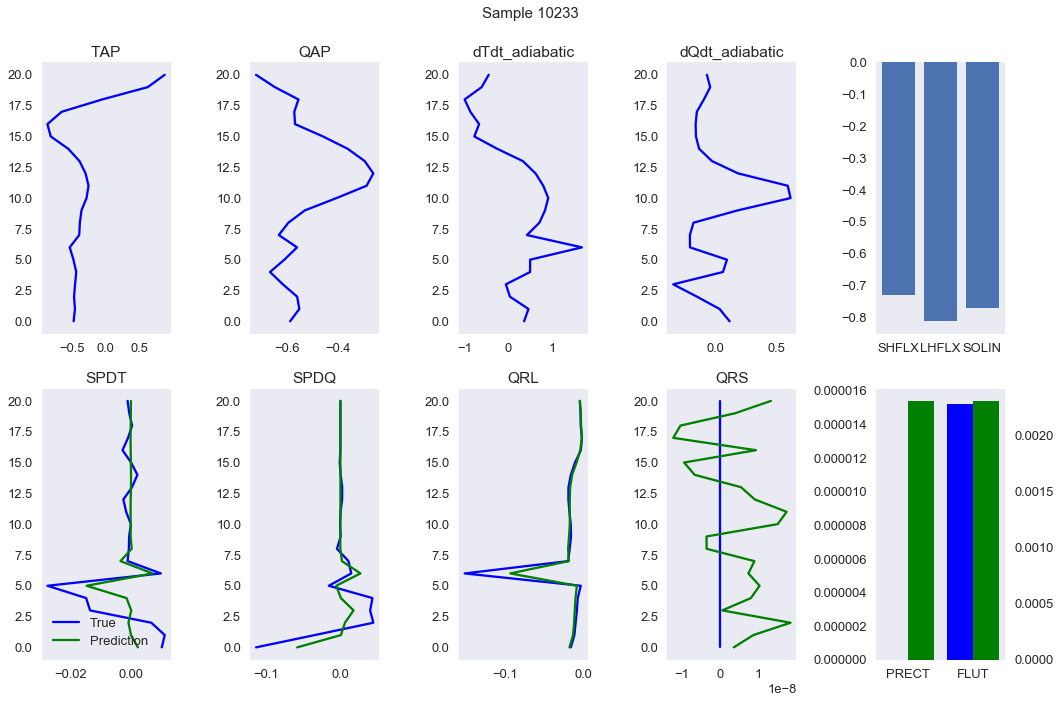

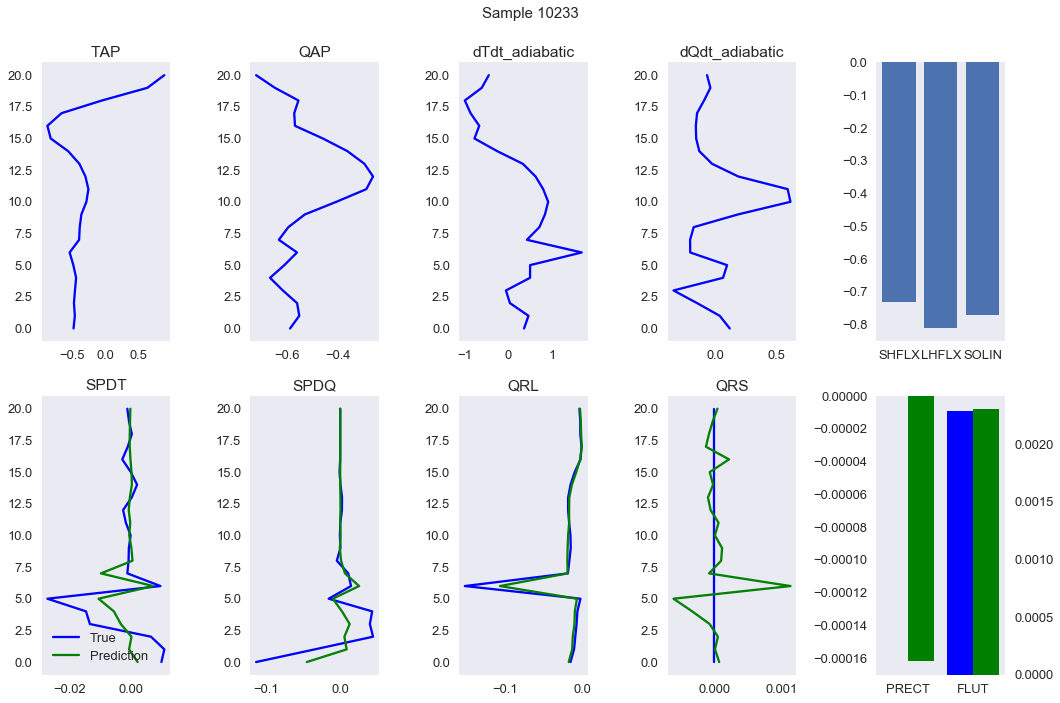

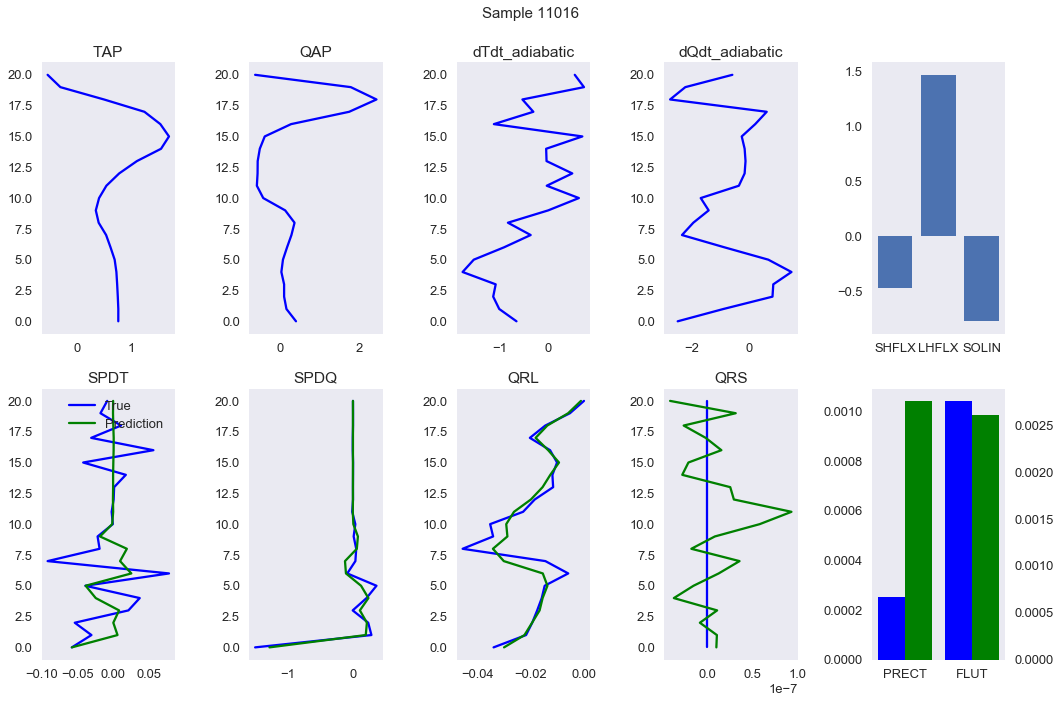

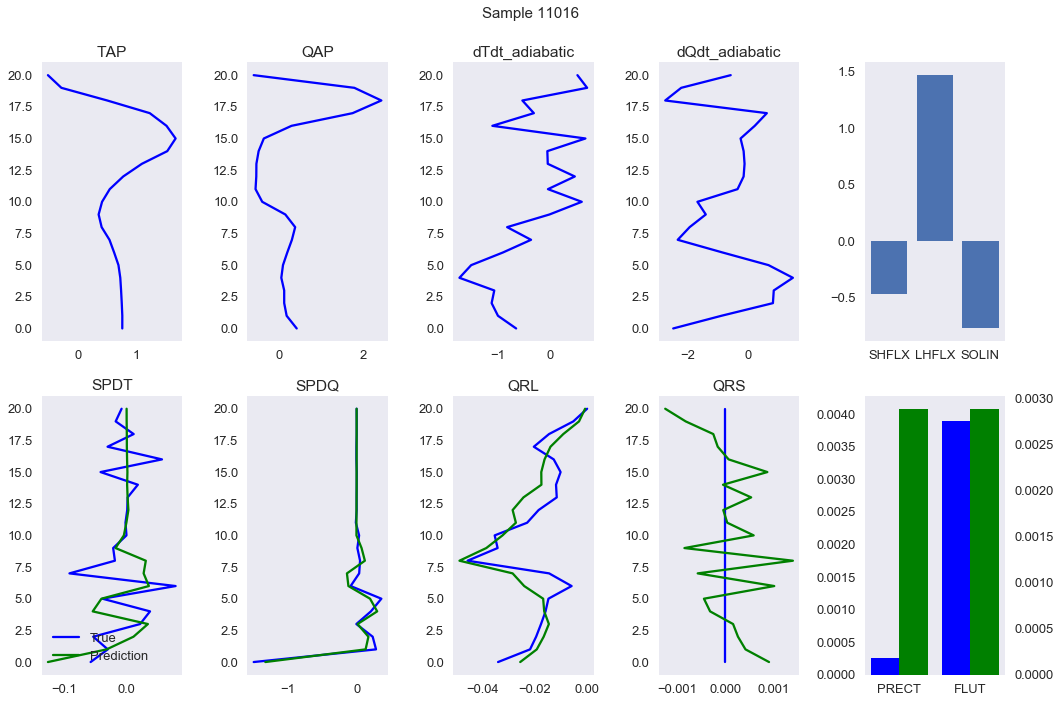

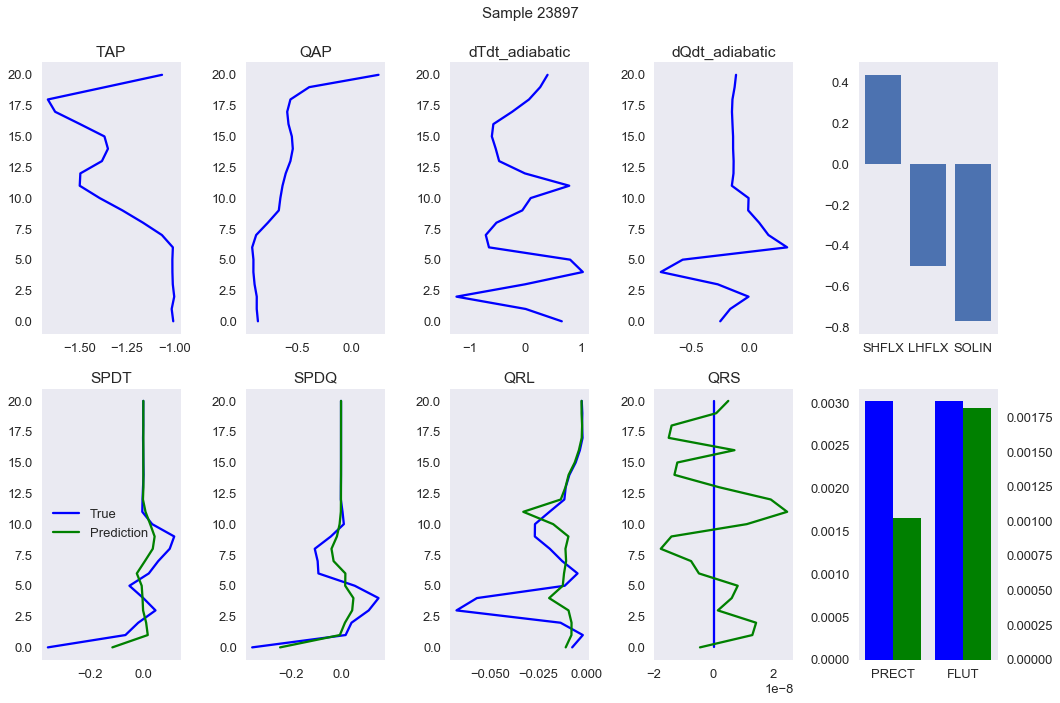

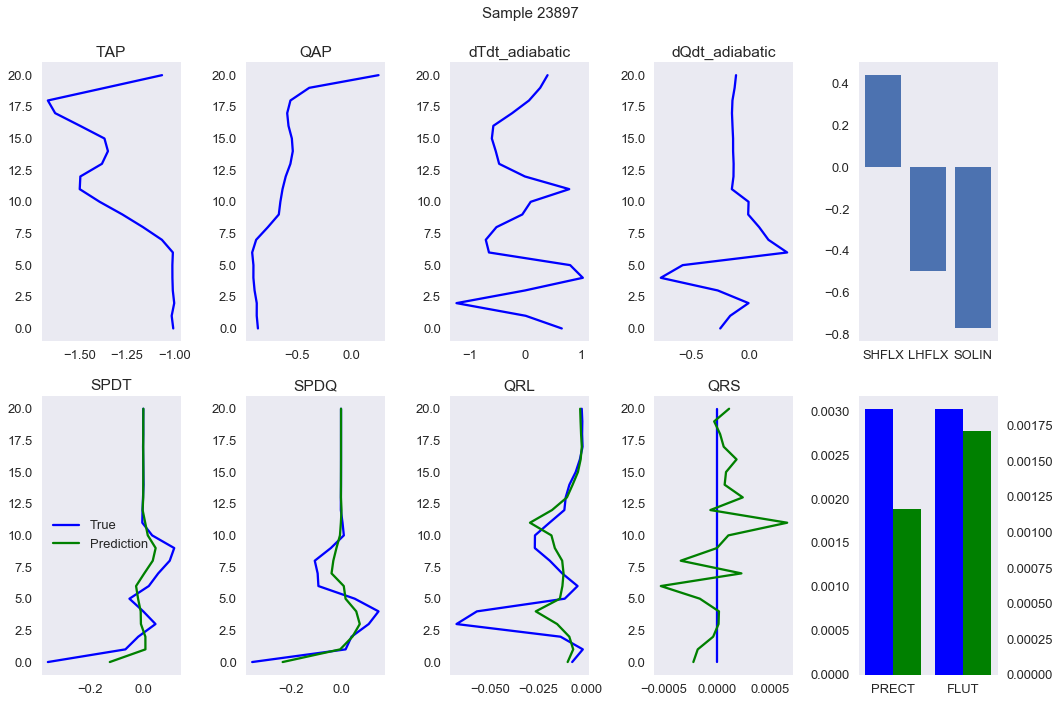

In [33]:
for i in list(np.random.randint(0, preds.shape[0], 10)):
    vis_features_targets_from_pred2(
        sample_features, 
        sample_targets, 
        preds,
        i, 
        feature_names, 
        target_names,
    )
    vis_features_targets_from_pred2(
        sample_features, 
        sample_targets, 
        preds_log,
        i, 
        feature_names, 
        target_names,
    )

### SPDT, SPDQ slices

In [34]:
# reshape
sample_targets_re = reshape_geo(sample_targets)
sample_preds_re = reshape_geo(preds)
sample_preds_re_log = reshape_geo(preds_log)

In [25]:
sample_targets_re.shape, sample_preds_re.shape

((3, 64, 128, 86), (3, 64, 128, 86))

In [26]:
def plot_yz(targets, preds, itime, ilon):
    fig, axes = plt.subplots(2, 2, figsize=(13,7))
    range_spdt = np.max(np.abs(targets[itime, :, ilon, :21]))
    range_spdq = np.max(np.abs(targets[itime, :, ilon, 21:42]))
    # Target SPDT
    I = axes[0, 0].imshow(targets[itime, :, ilon, :21].T,
                       vmin=-range_spdt, vmax=range_spdt, cmap='bwr')
    axes[0, 0].set_title('Target SPDT')
    fig.colorbar(I, ax=axes[0, 0], shrink=0.4)
    # Pred SPDT
    I = axes[1, 0].imshow(preds[itime, :, ilon, :21].T,
                       vmin=-range_spdt, vmax=range_spdt, cmap='bwr')
    axes[1, 0].set_title('Predicted SPDT')
    fig.colorbar(I, ax=axes[1, 0], shrink=0.4)
    # Target SPDQ
    I = axes[0, 1].imshow(targets[itime, :, ilon, 21:42].T,
                       vmin=-range_spdq, vmax=range_spdq, cmap='bwr')
    axes[0, 1].set_title('Target SPDQ')
    fig.colorbar(I, ax=axes[0, 1], shrink=0.4)
    # Pred SPDQ
    I = axes[1, 1].imshow(preds[itime, :, ilon, 21:42].T,
                       vmin=-range_spdq, vmax=range_spdq, cmap='bwr')
    axes[1, 1].set_title('Predicted SPDQ')
    fig.colorbar(I, ax=axes[1, 1], shrink=0.4)
    plt.tight_layout()
    plt.show()

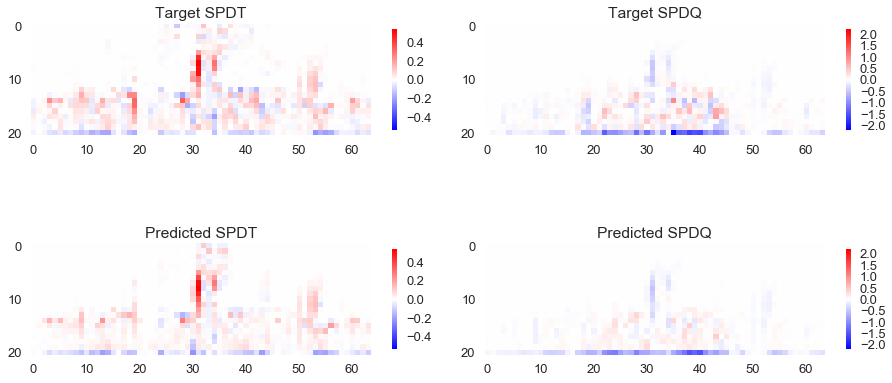

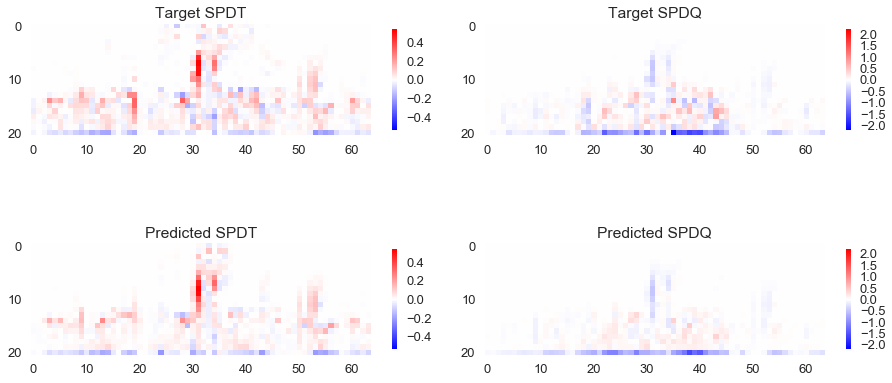

In [35]:
plot_yz(sample_targets_re, sample_preds_re, 0, 10)
plot_yz(sample_targets_re, sample_preds_re_log, 0, 10)

### PREC, OLR slices

In [28]:
def plot_xy(targets_re, preds_re, itime, ifeat):
    feat_name = target_names[ifeat]
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    mn = np.minimum(targets_re[itime, :, :, ifeat], 
                    preds_re[itime, :, :, ifeat]).min()
    mx = np.maximum(targets_re[itime, :, :, ifeat], 
                    preds_re[itime, :, :, ifeat]).max()
    I = axes[0].imshow(targets_re[itime, :, :, ifeat], cmap='inferno_r', vmin=mn, vmax=mx)
    axes[0].set_title('True ' + feat_name)
    fig.colorbar(I, ax=axes[0], shrink=0.8, orientation='horizontal')
    I = axes[1].imshow(preds_re[itime, :, :, ifeat], cmap='inferno_r', vmin=mn, vmax=mx)
    axes[1].set_title('Predicted ' + feat_name)
    fig.colorbar(I, ax=axes[1], shrink=0.8, orientation='horizontal')
    error = preds_re[itime, :, :, ifeat] - targets_re[itime, :, :, ifeat]
    mx_err = np.max(np.abs(error))
    I = axes[2].imshow(error, cmap='bwr', vmin=-mx_err, vmax=mx_err)
    axes[2].set_title('Error ' + feat_name)
    fig.colorbar(I, ax=axes[2], shrink=0.8, orientation='horizontal')
    plt.tight_layout(); plt.show()

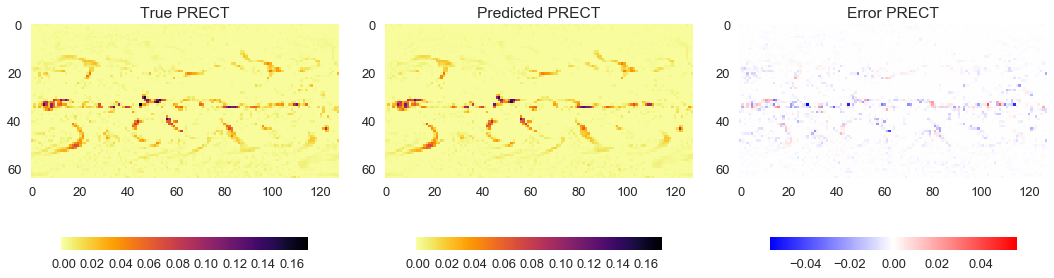

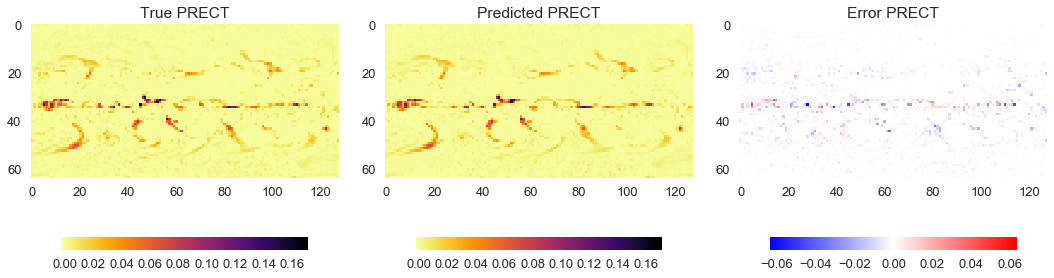

In [36]:
plot_xy(sample_targets_re, sample_preds_re, 0, -2)
plot_xy(sample_targets_re, sample_preds_re_log, 0, -2)

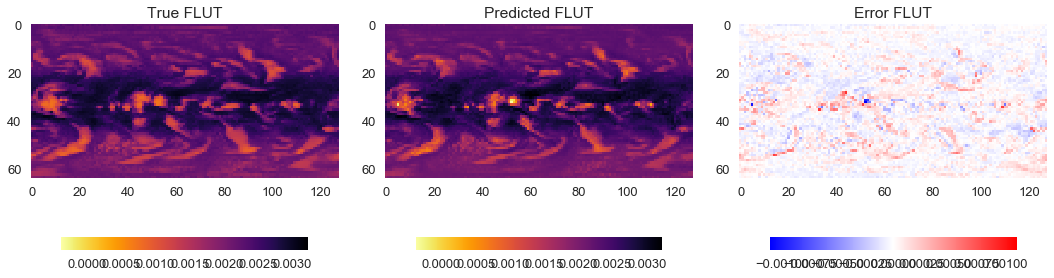

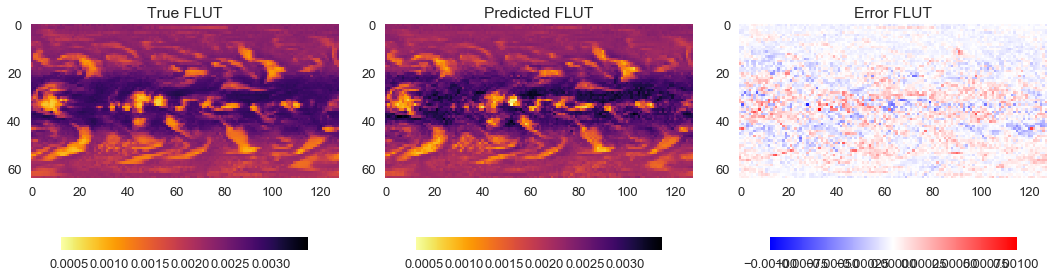

In [37]:
plot_xy(sample_targets_re, sample_preds_re, 1, -1)
plot_xy(sample_targets_re, sample_preds_re_log, 1, -1)